In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

In [2]:
START_DATE = '2003-03-31'
END_DATE = '2009-03-31'

# 減少入選股數 - 台股

## import

In [3]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
# from dataframe import CustomDataFrame
import plot_data

## get data

In [4]:
data=Data()

---

## 畫圖 Function

In [123]:
from matplotlib.ticker import PercentFormatter

def plot_diff_period_cagr(report_collec, title='CAGR 比較'):
    """
    將策略分為以'2003~2009'和'2009~2024'結尾的兩個CAGR折線圖，並顯示在同一圖表上

    參數:
    report_collec: 策略報告集合
    title: 圖表標題

    返回: 顯示圖表
    """

    reports = report_collec.reports

    strategies_2003 = []
    cagr_values_2003 = []
    strategies_2009 = []
    cagr_values_2009 = []

    # 獲得每個策略的CAGR，並根據命名進行分類
    for strategy_name, report in reports.items():
        if strategy_name.endswith('2003~2009'):
            prefix = strategy_name.replace('_2003~2009', '')
            strategies_2003.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_2003.append(cagr)
        elif strategy_name.endswith('2009~2024'):
            prefix = strategy_name.replace('_2009~2024', '')
            strategies_2009.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_2009.append(cagr)

    # 確保兩個列表的長度一致，以保持x軸一致性
    all_prefixes = sorted(list(set(strategies_2003) | set(strategies_2009)))
    all_prefixes.sort()

    cagr_values_2003_aligned = [cagr_values_2003[strategies_2003.index(prefix)] if prefix in strategies_2003 else None for prefix in all_prefixes]
    cagr_values_2009_aligned = [cagr_values_2009[strategies_2009.index(prefix)] if prefix in strategies_2009 else None for prefix in all_prefixes]

    # 繪製同一張圖上的兩條線
    plt.figure(figsize=(10, 6))

    plt.plot(all_prefixes, cagr_values_2003_aligned, marker='o', label='2003~2009', color='tab:blue')
    plt.plot(all_prefixes, cagr_values_2009_aligned, marker='o', label='2009~2024', color='tab:orange')

    # 設定圖表標題與軸標籤
    plt.title(title)
    # plt.xlabel('')
    plt.ylabel('CAGR (%)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter())

    # 設定 x 軸刻度及旋轉角度
    plt.xticks(rotation=90, ha='right', fontsize=10)

    # 添加網格線和圖例
    plt.grid(True, alpha=0.7, axis='y', linestyle='--')
    plt.legend()

    plt.tight_layout()

    # 顯示圖表
    plt.show()

In [6]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import PercentFormatter

def plot_diff_PER_cagr(report_collec, title='CAGR 比較'):
    """
    將策略分為以'PE_10'和'PE_12'結尾的兩個CAGR折線圖，並顯示在同一圖表上

    參數:
    report_collec: 策略報告集合
    title: 圖表標題

    返回: 顯示圖表
    """

    reports = report_collec.reports

    strategies_pe10 = []
    cagr_values_pe10 = []
    strategies_pe12 = []
    cagr_values_pe12 = []

    # 獲得每個策略的CAGR，並根據命名進行分類
    for strategy_name, report in reports.items():
        if strategy_name.endswith('PE_10'):
            prefix = strategy_name.replace('_PE_10', '')
            strategies_pe10.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe10.append(cagr)
        elif strategy_name.endswith('PE_12'):
            prefix = strategy_name.replace('_PE_12', '')
            strategies_pe12.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe12.append(cagr)

    # 確保兩個列表的長度一致，以保持x軸一致性
    all_prefixes = sorted(list(set(strategies_pe10) | set(strategies_pe12)))

    cagr_values_pe10_aligned = [cagr_values_pe10[strategies_pe10.index(prefix)] if prefix in strategies_pe10 else None for prefix in all_prefixes]
    cagr_values_pe12_aligned = [cagr_values_pe12[strategies_pe12.index(prefix)] if prefix in strategies_pe12 else None for prefix in all_prefixes]

    # 繪製同一張圖上的兩條線
    plt.figure(figsize=(10, 6))

    plt.plot(all_prefixes, cagr_values_pe10_aligned, marker='o', label='PE_10', color='tab:blue')
    plt.plot(all_prefixes, cagr_values_pe12_aligned, marker='o', label='PE_12', color='tab:orange')

    # 設定圖表標題與軸標籤
    plt.title(title)
    plt.xlabel('配息率三年至少>多少%')
    plt.ylabel('CAGR (%)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter())

    # 設定 x 軸刻度及旋轉角度
    plt.xticks(rotation=90, ha='right', fontsize=10)

    # 添加網格線和圖例
    plt.grid(True, alpha=0.7, axis='y', linestyle='--')
    plt.legend()

    plt.tight_layout()

    # 顯示圖表
    plt.show()

In [7]:
def compare_stock_dicts(dict1, dict2):
    # 將兩個 dict 的年份取出，找到所有的年份
    all_years = set(dict1.keys()).union(set(dict2.keys()))
    
    # 初始化結果的字典
    result = {}
    
    # 遍歷每一個年份進行比較
    for year in all_years:
        # 取出 dict1 和 dict2 中這一年的 list，若沒有該年份則給空集合
        set1 = set(dict1.get(year, []))
        set2 = set(dict2.get(year, []))
        
        # 計算只在 dict1、只在 dict2 以及共同擁有的元素
        only_in_dict1 = set1 - set2
        only_in_dict2 = set2 - set1
        common = set1 & set2
        
        # 結果dict
        result[year] = {
            "only_in_dict1": list(only_in_dict1),
            "only_in_dict2": list(only_in_dict2),
            "common": list(common)
        }
    
    # print result
    for year, comparison in result.items():
        print(f"# {year} 年:")
        print(f"  Only in dict1: {', '.join(comparison['only_in_dict1']) if comparison['only_in_dict1'] else 'None'}")
        print(f"  Only in dict2: {', '.join(comparison['only_in_dict2']) if comparison['only_in_dict2'] else 'None'}")
        print(f"  Common: {', '.join(comparison['common']) if comparison['common'] else 'None'}")
        print('-' * 40)  # 分隔線
    
    return result

---

## 資料下載

### **盈餘再投資率**

In [8]:
profit = data.get('annual_report_fundamentals:常續性稅後淨利')

In [9]:
# 抓資料
long_term_items = [
    '透過損益按公允價值衡量之金融資產－非流動',
    '透過其他綜合損益按公允價值衡量之金融資產－非流動',
    '按攤銷後成本衡量之金融資產－非流動',
    '避險之金融資產－非流動',
    '合約資產－非流動',
    '採權益法之長期股權投資',
    '預付投資款',
    '投資性不動產淨額'
]

# 長期投資項目 (8個)
long_term_data = [data.get(f'annual_report_fundamentals:{item}').fillna(0) for item in long_term_items]
long_term_investment = sum(long_term_data)
# 固定資產
fixed_assets_year = data.get('annual_report_fundamentals:不動產廠房及設備').fillna(0)

In [10]:
# 計算盈再率分子
long_term_investment_df = (long_term_investment - long_term_investment.shift(4))
fixed_assets_df = (fixed_assets_year - fixed_assets_year.shift(4))

In [11]:
profit_rol_df = profit.rolling(4).sum()['2000':]

In [12]:
# 計算出盈再率
# 去掉淨利為負的公司 (當年度淨利為負、四年加總淨利為負都去掉)
rr = (long_term_investment_df + fixed_assets_df) / profit_rol_df
rr = rr[(profit > 0) & (profit_rol_df > 0)]

---

### **本益比 (P/E)**
- 每季資料
- 每日資料

In [13]:
pe = data.get('quarter_report:PE') #[START_DATE:END_DATE]
daily_pe = data.get('price:daily_pe') #[START_DATE:END_DATE]


#### 本益比數值

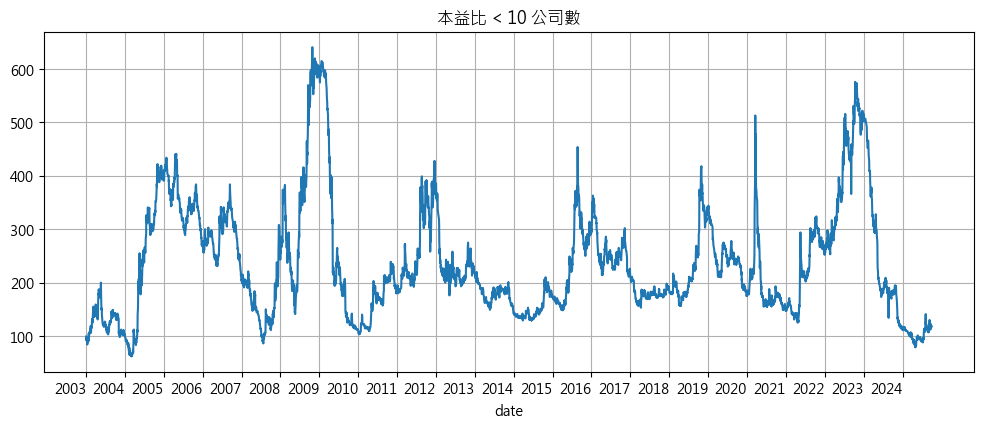

In [14]:
ax = ((daily_pe < 10)['2003':]).sum(axis=1).plot(figsize=(12, 5))

ax.grid(True)
ax.tick_params(axis='x', rotation=0)

# 標記出x軸所有年份
ax.set_xticks(pd.date_range(start='2003', end=daily_pe.index.max(), freq='YS'))
ax.set_xticklabels([x.year for x in pd.date_range(start='2003', end=daily_pe.index.max(), freq='YS')])

ax.set_title("本益比 < 10 公司數")
plt.show()

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (不一定有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report_fundamentals:ROE(A)－稅後')
payout_ratio = data.get('annual_report_fundamentals:股利支付率')

In [16]:
stock_hold = data.get('annual_report_fundamentals:董監持股%')

##### 上市上櫃滿兩年

In [17]:
close = data.get('price:close')

listed_date = data.get('company_profile')
listed_date['ipo_date'] = pd.to_datetime(listed_date['ipo_date'])

# 創建一個字典來存儲各股票的資料
stock_data = {}

# 遍歷 listed_date，對應每支股票代號，設置 False 和 True 的值
for index, row in listed_date.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

# 上市櫃滿兩年
listed = pd.concat(stock_data, axis=1)
# listed_all = listed.resample('M').last()
listed = listed.resample('M').last()

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 80%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [18]:
# ROE 5年平均 > 15%
roe_rol = roe.rolling(5).mean()
roe_15 = (roe_rol > 15) #[START_DATE:END_DATE]

In [19]:
rr_cond = (rr < 0.4) #[START_DATE:END_DATE]

In [20]:
# *最近3年的配息率有無一年不及40%*
payout_ratio_cond = (payout_ratio.rolling(3).min() >= 40) #[START_DATE:END_DATE]

# # 金融股看配息率，不看盈再率
# rr_cond[finance_stock_list] = payout_ratio_cond[finance_stock_list]

In [21]:
# 淨利 > 5億
profit_cond = (profit > 500000) # [START_DATE:END_DATE] # TEJ 的淨利單位是千元

In [22]:
hold_cond = (stock_hold > 10) #[START_DATE:END_DATE]

---

## 原始條件 + 無本益比進出場條件

In [23]:
# 原始條件、無本益比進出場
orig_all = roe_15 & (rr < 0.8) & payout_ratio_cond & profit_cond & hold_cond & listed # 盈再率 < 0.8
orig_all_opt = roe_15 & rr_cond & payout_ratio_cond & profit_cond & hold_cond & listed # 盈再率 < 0.4

### 盈再率 < 0.8，無本益比

In [24]:
# rep_all_cond = backtest.sim(orig_all[START_DATE:END_DATE], resample='M', data=data)
# rep_all_cond.get_stats()

### 盈再率 < 0.4，無本益比

In [25]:
rep_all_cond_opt = backtest.sim(orig_all_opt[START_DATE:END_DATE], resample='M', data=data)
rep_all_cond_opt.get_stats()

{'CAGR': 0.11268611669689244,
 'daily_sharpe': 50.25,
 'max_drawdown': -0.539349166982074,
 'avg_drawdown': -0.08419894560155382,
 'win_ratio': 0.4117647058823529,
 'ytd': 0.21796598152607816}

## 原始條件 + 有本益比進出場

### 每季本益比

In [26]:
# # (每季)本益比條件

pe_cond_entry = (pe < 12).resample('M').last()
pe_cond_exit = (pe > 30).resample('M').last()


# orig_all_cond_and_pe = (orig_all[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

# rep_all_cond_and_pe = backtest.sim(orig_all_cond_and_pe, resample='M', data=data)
# rep_all_cond_and_pe.get_stats()

In [27]:
orig_all_cond_pe_opt = (orig_all_opt[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

rep_all_cond_pe_opt = backtest.sim(orig_all_cond_pe_opt, resample='M', data=data)
rep_all_cond_pe_opt.get_stats()

{'CAGR': 0.09786843924652389,
 'daily_sharpe': 51.78,
 'max_drawdown': -0.5605033870688143,
 'avg_drawdown': -0.08946567191025552,
 'win_ratio': 0.5151515151515151,
 'ytd': 0.238012829015551}

### 每月本益比

In [28]:
# 每日本益比resample成每月
daily_pe_resample = daily_pe.resample('M').last()

pe_cond_entry_daily = (daily_pe_resample < 12) #[START_DATE:END_DATE]
pe_cond_exit_daily = (daily_pe_resample > 30) #[START_DATE:END_DATE]

### 盈再率 < 80%

In [29]:
# orig_all_pe_daily = ((orig_all[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE]))

# rep_orig_pe_daily = backtest.sim(orig_all_pe_daily, resample='M', data=data)
# rep_orig_pe_daily.display()

### 盈再率 < 40%

In [30]:
orig_all_opt_pe_daily = (orig_all_opt[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

rep_orig_opt_pe_daily = backtest.sim(orig_all_opt_pe_daily, resample='M', data=data)
rep_orig_opt_pe_daily.get_stats()

{'CAGR': 0.11400317317658581,
 'daily_sharpe': 49.22,
 'max_drawdown': -0.5518044373276076,
 'avg_drawdown': -0.08524276518939392,
 'win_ratio': 0.42857142857142855,
 'ytd': 0.22999059355756812}

In [31]:
pos_comp_return, neg_comp_return = rep_orig_opt_pe_daily.calc_returns_contrib(5)

In [32]:
# print(roe[['2498']]['2010':'2010'])
# print(roe_rol[['2498']]['2006':'2010'])
# print(rr[['2498']]['2006':'2010'])

In [33]:
# rep_all_cond_and_pe_daily.position

---

## ROE五年平均+配息率參數最佳化

### 2003~2009 vs 2009~2024

In [34]:
roe_payout_strat_opt={}

# base_conds = ((rr < 0.8) & profit_cond & hold_cond & listed)[START_DATE:END_DATE]
base_opt_conds = (rr_cond & profit_cond & hold_cond & listed)[START_DATE:END_DATE]



for i in range(15, 26, 5):
    for j in range(25, 71, 5):

        roe_rol_opt_cond = (roe_rol > i)[START_DATE:END_DATE]
        dpr_cond_opt = (payout_ratio.rolling(3).min() >= j)[START_DATE:END_DATE]

        # all_cond_base = (base_conds & roe_rol_opt_cond & dpr_cond_opt)[START_DATE:END_DATE]
        all_opt_conds = (base_opt_conds & roe_rol_opt_cond & dpr_cond_opt)[START_DATE:END_DATE]

        # ROE 5年平均 > {i}% + 配息率3年至少{j}%
        # roe_payout_strat_opt[f'ROE平均_{i}_配息_{j}_盈再率80'] = (all_cond_base & pe_cond_entry_daily).hold_until(~all_cond_base | pe_cond_exit_daily)
        roe_payout_strat_opt[f'ROE平均_{i}_配息_{j}'] = (all_opt_conds & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until(~all_opt_conds | pe_cond_exit_daily[START_DATE:END_DATE])

roe_payout_strat_opt_comb = sim_conditions(roe_payout_strat_opt, resample='M', data=data)
# roe_payout_strat_opt_comb.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 30/30 [00:58<00:00,  1.94s/condition]


In [35]:
roe_payout_strat_opt_comb.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數    25%    75%  Min   Max
Strategy                                                                
ROE平均_25_配息_25     17.18   -59.84   16.18  15.0  12.75  22.25  1.0  27.0
ROE平均_20_配息_50     14.02   -57.72    9.07   6.0   2.00  15.00  1.0  26.0
ROE平均_20_配息_35     14.02   -56.72   14.22  13.0   3.00  24.00  1.0  35.0
ROE平均_20_配息_45     13.86   -58.31   11.15   9.0   2.00  18.00  1.0  30.0
ROE平均_25_配息_70     13.67   -54.12    2.59   1.0   1.00   4.00  1.0   8.0
ROE平均_25_配息_65     13.10   -54.08    2.86   1.0   1.00   5.00  1.0   9.0
ROE平均_20_配息_25     12.49   -57.39   17.11  16.0   4.00  28.00  1.0  40.0
ROE平均_15_配息_35     11.99   -55.38   26.67  30.0   8.00  40.00  2.0  57.0
ROE平均_15_配息_45     11.89   -55.21   21.29  24.0   5.00  34.00  1.0  50.0
ROE平均_15_配息_25     11.59   -55.76   31.37  34.0  13.00  46.00  2.0  63.0
ROE平均_20_配息_40     11.54   -58.04   12.00  11.0   3.00  19.00  1.0  31.0
ROE平均_15_配息_30     11.40   -54.88   29.75  33.0  11.00  44.00  2.0  60.0
ROE平均_15_配息_40     11.40   -55.18   23.11  27.0   6.00  35.00  2.0  52.0
ROE平均_20_配息_70     10.93   -56.29    3.70   2.0   1.00   4.00  1.0  12.0
ROE平均_20_配息_65     10.55   -54.92    4.61   2.0   1.00   4.00  1.0  17.0
ROE平均_15_配息_50     10.54   -55.90   18.27  19.0   4.00  30.00  1.0  45.0
ROE平均_20_配息_30     10.26   -56.09   15.81  15.0   3.00  26.00  1.0  37.0
ROE平均_25_配息_35     10.19   -57.69   14.33  13.0   9.00  19.00  1.0  25.0
ROE平均_15_配息_55      9.82   -56.23   15.99  17.0   4.00  25.00  1.0  41.0
ROE平均_20_配息_60      9.76   -57.58    7.61   5.0   2.00  11.00  2.0  21.0
ROE平均_25_配息_30      9.21   -59.43   16.10  15.0  12.00  21.00  1.0  26.0
ROE平均_15_配息_70      8.43   -51.36    6.93   6.0   4.00   8.00  2.0  17.0
ROE平均_20_配息_55      8.27   -58.87    9.39   7.0   6.00  12.00  2.0  23.0
ROE平均_25_配息_55      7.85   -61.06    8.00   6.0   5.00  10.00  4.0  15.0
ROE平均_15_配息_65      7.84   -53.18   10.31   8.0   5.00  11.00  2.0  29.0
ROE平均_15_配息_60      7.59   -56.17   14.75  12.0   7.00  20.00  3.0  37.0
ROE平均_25_配息_60      7.54   -62.12    6.27   4.0   3.00   8.00  2.0  13.0
ROE平均_25_配息_45      6.95   -62.42   11.55   9.0   7.00  14.00  5.0  20.0
ROE平均_25_配息_40      6.35   -61.87   12.20  10.0   8.00  15.00  5.0  21.0
ROE平均_25_配息_50      6.17   -62.00    9.14   6.0   5.00  12.00  4.0  18.0

In [36]:
roe_payout_strat_opt_2009={}

# base_conds = ((rr < 0.8) & profit_cond & hold_cond & listed)[START_DATE:END_DATE]
base_opt_conds = (rr_cond & profit_cond & hold_cond & listed)['2009-3':]



for i in range(15, 26, 5):
    for j in range(25, 71, 5):

        roe_rol_opt_cond = (roe_rol > i)['2009-3':]
        dpr_cond_opt = (payout_ratio.rolling(3).min() >= j)['2009-3':]

        # all_cond_base = (base_conds & roe_rol_opt_cond & dpr_cond_opt)[START_DATE:END_DATE]
        all_opt_conds = base_opt_conds & roe_rol_opt_cond & dpr_cond_opt

        # ROE 5年平均 > {i}% + 配息率3年至少{j}%
        # roe_payout_strat_opt[f'ROE平均_{i}_配息_{j}_盈再率80'] = (all_cond_base & pe_cond_entry_daily).hold_until(~all_cond_base | pe_cond_exit_daily)
        roe_payout_strat_opt_2009[f'ROE平均_{i}_配息_{j}_2009~2024'] = (all_opt_conds & pe_cond_entry_daily['2009-3':]).hold_until(~all_opt_conds | pe_cond_exit_daily['2009-3':])

roe_payout_strat_opt_comb_2009 = sim_conditions(roe_payout_strat_opt_2009, resample='M', data=data)
# roe_payout_strat_opt_comb_2009.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 30/30 [00:59<00:00,  1.97s/condition]


In [37]:
roe_payout_strat_opt_comb_2009.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min  \
Strategy                                                                      
ROE平均_15_配息_70_2009~2024     15.83   -30.14   12.76  13.0  10.0  15.0   4.0   
ROE平均_15_配息_45_2009~2024     15.05   -30.55   36.67  36.0  31.0  41.0  23.0   
ROE平均_15_配息_65_2009~2024     14.81   -29.68   16.78  16.0  14.0  20.0   6.0   
ROE平均_15_配息_50_2009~2024     14.79   -29.94   31.45  30.0  25.5  36.0  18.0   
ROE平均_15_配息_40_2009~2024     14.72   -30.55   39.64  38.0  33.0  43.0  25.0   
ROE平均_15_配息_30_2009~2024     14.70   -30.64   43.60  42.0  36.0  48.0  28.0   
ROE平均_15_配息_35_2009~2024     14.67   -30.64   41.81  41.0  34.0  46.0  27.0   
ROE平均_15_配息_60_2009~2024     14.55   -29.22   21.40  20.0  16.0  26.0  10.0   
ROE平均_15_配息_25_2009~2024     14.51   -31.02   44.38  42.0  37.0  48.0  29.0   
ROE平均_15_配息_55_2009~2024     14.44   -28.59   27.43  27.0  23.0  32.0  13.0   
ROE平均_20_配息_70_2009~2024     12.35   -38.45    6.04   6.0   4.0   7.0   2.0   
ROE平均_20_配息_65_2009~2024     12.03   -39.04    8.14   8.0   7.0  10.0   4.0   
ROE平均_20_配息_30_2009~2024     11.89   -32.57   22.24  21.0  16.0  28.0  10.0   
ROE平均_20_配息_60_2009~2024     11.76   -38.74   10.48  10.0   8.0  13.0   4.0   
ROE平均_20_配息_35_2009~2024     11.66   -32.57   21.40  19.0  16.0  27.0   9.0   
ROE平均_20_配息_25_2009~2024     11.50   -33.32   22.51  22.0  17.0  28.0  10.0   
ROE平均_20_配息_40_2009~2024     10.95   -32.57   20.21  19.0  16.0  24.5   9.0   
ROE平均_25_配息_70_2009~2024     10.78   -43.56    2.31   2.0   1.0   3.0   0.0   
ROE平均_20_配息_45_2009~2024     10.75   -32.57   18.85  18.0  15.0  22.0   9.0   
ROE平均_20_配息_55_2009~2024     10.63   -37.30   13.96  13.0  12.0  16.0   6.0   
ROE平均_20_配息_50_2009~2024     10.47   -32.92   16.11  15.0  13.0  18.0   6.0   
ROE平均_25_配息_30_2009~2024     10.02   -38.65   10.42  10.0   5.5  13.0   3.0   
ROE平均_25_配息_65_2009~2024      9.95   -35.21    3.50   3.0   3.0   5.0   0.0   
ROE平均_25_配息_25_2009~2024      9.28   -39.80   10.55  10.0   6.0  13.0   3.0   
ROE平均_25_配息_35_2009~2024      9.04   -38.04    9.82   9.0   5.0  12.0   3.0   
ROE平均_25_配息_60_2009~2024      8.91   -35.56    4.81   5.0   3.0   6.0   0.0   
ROE平均_25_配息_50_2009~2024      8.55   -38.04    7.17   7.0   4.0  10.0   3.0   
ROE平均_25_配息_45_2009~2024      8.19   -38.04    8.58   9.0   5.0  11.0   3.0   
ROE平均_25_配息_40_2009~2024      7.91   -38.04    9.32   9.0   5.0  12.0   3.0   
ROE平均_25_配息_55_2009~2024      7.06   -37.62    6.25   7.0   4.0   8.0   1.0   

                           Max  
Strategy                        
ROE平均_15_配息_70_2009~2024  21.0  
ROE平均_15_配息_45_2009~2024  58.0  
ROE平均_15_配息_65_2009~2024  26.0  
ROE平均_15_配息_50_2009~2024  50.0  
ROE平均_15_配息_40_2009~2024  63.0  
ROE平均_15_配息_30_2009~2024  72.0  
ROE平均_15_配息_35_2009~2024  69.0  
ROE平均_15_配息_60_2009~2024  37.0  
ROE平均_15_配息_25_2009~2024  73.0  
ROE平均_15_配息_55_2009~2024  43.0  
ROE平均_20_配息_70_2009~2024  11.0  
ROE平均_20_配息_65_2009~2024  13.0  
ROE平均_20_配息_30_2009~2024  36.0  
ROE平均_20_配息_60_2009~2024  17.0  
ROE平均_20_配息_35_2009~2024  36.0  
ROE平均_20_配息_25_2009~2024  37.0  
ROE平均_20_配息_40_2009~2024  33.0  
ROE平均_25_配息_70_2009~2024   7.0  
ROE平均_20_配息_45_2009~2024  29.0  
ROE平均_20_配息_55_2009~2024  22.0  
ROE平均_20_配息_50_2009~2024  26.0  
ROE平均_25_配息_30_2009~2024  22.0  
ROE平均_25_配息_65_2009~2024   8.0  
ROE平均_25_配息_25_2009~2024  23.0  
ROE平均_25_配息_35_2009~2024  22.0  
ROE平均_25_配息_60_2009~2024  10.0  
ROE平均_25_配息_50_2009~2024  15.0  
ROE平均_25_配息_45_2009~2024  17.0  
ROE平均_25_配息_40_2009~2024  21.0  
ROE平均_25_配息_55_2009~2024  13.0

---

## 加上當年度 ROE < 15% 時出場條件

### 盈再率 < 80%

In [38]:
# orig_pe_roe = (orig_all & pe_cond_entry_daily).hold_until((~orig_all) | pe_cond_exit_daily | (roe[START_DATE:END_DATE] < 15))

# rep_orig_pe_roe = backtest.sim(orig_pe_roe, resample='M', data=data)
# rep_orig_pe_roe.display()

### 盈再率 < 40%

In [39]:
orig_all_opt_pe_roe = (orig_all_opt[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15))

rep_orig_opt_pe_roe = backtest.sim(orig_all_opt_pe_roe, resample='M', data=data)
rep_orig_opt_pe_roe.get_stats()

{'CAGR': 0.13802881961698632,
 'daily_sharpe': 45.24,
 'max_drawdown': -0.5525890553561017,
 'avg_drawdown': -0.08548471197768179,
 'win_ratio': 0.3829787234042553,
 'ytd': 0.23828980551862422}

---

## 本益比進場條件設更低

### 本益比 < 10 進場

In [40]:
pe_entry_opt = daily_pe_resample < 10

#### 盈再率 < 80%

In [41]:
# orig_opt_pe = (orig_all & pe_entry_opt).hold_until((~orig_all) | pe_cond_exit_daily)

# orig_rep_opt_pe = backtest.sim(orig_opt_pe, resample='M', data=data)
# orig_rep_opt_pe.display()

#### 盈再率 < 40%

In [42]:
lower_rr_opt_pe = (orig_all_opt[START_DATE:END_DATE] & pe_entry_opt[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

lower_rr_rep_opt_pe = backtest.sim(lower_rr_opt_pe, resample='M', data=data)
lower_rr_rep_opt_pe.get_stats()

{'CAGR': 0.08927127152301573,
 'daily_sharpe': 53.45,
 'max_drawdown': -0.5627148593269911,
 'avg_drawdown': -0.08888154791901742,
 'win_ratio': 0.43333333333333335,
 'ytd': 0.24468117655279364}

### 本益比 < 10 + ROE < 15% 剃除

#### 盈再率 < 80%

In [43]:
# lower_roe_pe_orig = (orig_all & pe_entry_opt).hold_until((~orig_all) | pe_cond_exit_daily | (roe < 15))

# orig_rep_lower_pe_roe = backtest.sim(lower_roe_pe_orig, resample='M', data=data)
# orig_rep_lower_pe_roe.get_stats()

#### 盈再率 < 40%

In [44]:
lower_roe_pe_cond = (orig_all_opt[START_DATE:END_DATE] & pe_entry_opt[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15))

rep_lower_pe_roe = backtest.sim(lower_roe_pe_cond, resample='M', data=data)
# rep_lower_pe_roe.get_stats()

In [45]:
rep_lower_pe_roe.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    13.92%  47.69      -55.16%     42.5%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-05-02 2009-04-01     2008-04-30    2009-03-31  0.035714     228   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
1710     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
2006     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
2404     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
2439     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.023256     100   
2603     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
3010     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
3014     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.022222      57   
3015     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
3035     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.022222      57   
5347     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
5434     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
6139     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.066667     743   
6188     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
6203     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
6206     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
6277     2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.035714     284   
6281     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
6505     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.066667     743   
9921     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.023256     100   
9925     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.024390     122   
9927     2007-12-03 2009-04-01     2007-11-30    2009-03-31  0.041667     327   
1723     2004-05-03        NaT     2004-04-30           NaT  1.000000    5031   
2103     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
2360     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2365     2006-06-01        NaT     2006-05-30           NaT  0.062500    4516   
2374     2008-04-01        NaT     2008-03-31           NaT  0.037037    4062   
2382     2008-04-01        NaT     2008-03-31           NaT  0.037037    4062   
2395     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2397     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2450     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2451     2008-02-01        NaT     2008-01-31           NaT  0.035714    4097   
2495     2007-11-01        NaT     2007-10-31           NaT  0.045455    4162   
2498     2008-11-03        NaT     2008-10-31           NaT  0.023256    3913   
2536     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2548     2006-04-03        NaT     2006-03-31           NaT  0.066667    4556   
2606     2005-04-01        NaT     2005-03-31           NaT  0.125000    4804   
2617     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
3034     2007-12-03        NaT     2007-11-30           NaT  0.041667    4140   
3293     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5471     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5478     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5508     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
5534     2009-04-01        NaT     2009-

### 本益比 < 8 進場

In [46]:
pe_entry_lower = daily_pe_resample < 8

#### 盈再率 < 80%

In [47]:
# orig_lower_pe = (orig_all & pe_entry_lower).hold_until((~orig_all) | pe_cond_exit_daily)

# orig_rep_lower_pe = backtest.sim(orig_lower_pe, resample='M', data=data)
# orig_rep_lower_pe.display()

#### 盈再率 < 40%

In [48]:
lower_pe_cond = (orig_all_opt[START_DATE:END_DATE] & pe_entry_lower[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

In [49]:
rep_all_lower_pe = backtest.sim(lower_pe_cond, resample='M', data=data)
rep_all_lower_pe.get_stats()

{'CAGR': 0.0380914114802533,
 'daily_sharpe': 59.47,
 'max_drawdown': -0.5797451311635367,
 'avg_drawdown': -0.12660122327697623,
 'win_ratio': 0.3684210526315789,
 'ytd': 0.2706079478863983}

### 本益比 < 8 + ROE < 15% 剃除

##### 盈再率 < 80%

In [50]:
# roe_pe_lower_orig = (orig_all & pe_entry_lower).hold_until((~orig_all) | pe_cond_exit_daily | (roe < 15))

# orig_lower_pe_roe = backtest.sim(roe_pe_lower_orig, resample='M', data=data)
# orig_lower_pe_roe.get_stats()

##### 盈再率 < 40%

In [51]:
lower_roe_pe_opt = (orig_all_opt[START_DATE:END_DATE] & pe_entry_lower[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 15))

rep_opt_lower_pe_roe = backtest.sim(lower_roe_pe_opt, resample='M', data=data)
rep_opt_lower_pe_roe.get_stats()

{'CAGR': 0.07429597818601974,
 'daily_sharpe': 53.7,
 'max_drawdown': -0.5805825261803111,
 'avg_drawdown': -0.12367263354805559,
 'win_ratio': 0.38461538461538464,
 'ytd': 0.2750443567393024}

---

## 原始條件 + 本益比參數最佳化

### 出場固定30

In [52]:
pe_opt_entry = {}

for pe_entries in range(8, 14, 2):
    pe_entry_opt = daily_pe_resample < pe_entries

    pe_opt_entry[f"PE_{pe_entries}_30_2003~2009"] = (orig_all_opt[START_DATE:END_DATE] & pe_entry_opt[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])
    pe_opt_entry[f"PE_{pe_entries}_30_2009~2024"] = (orig_all_opt['2009-3':] & pe_entry_opt['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':])


pe_entry_opt_collecs = sim_conditions(pe_opt_entry, resample='M',data=data)
pe_entry_opt_collecs.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 6/6 [00:14<00:00,  2.48s/condition]


In [53]:
# pe_entry_opt_collecs.reports['PE_10_30_2009~2024'].display()

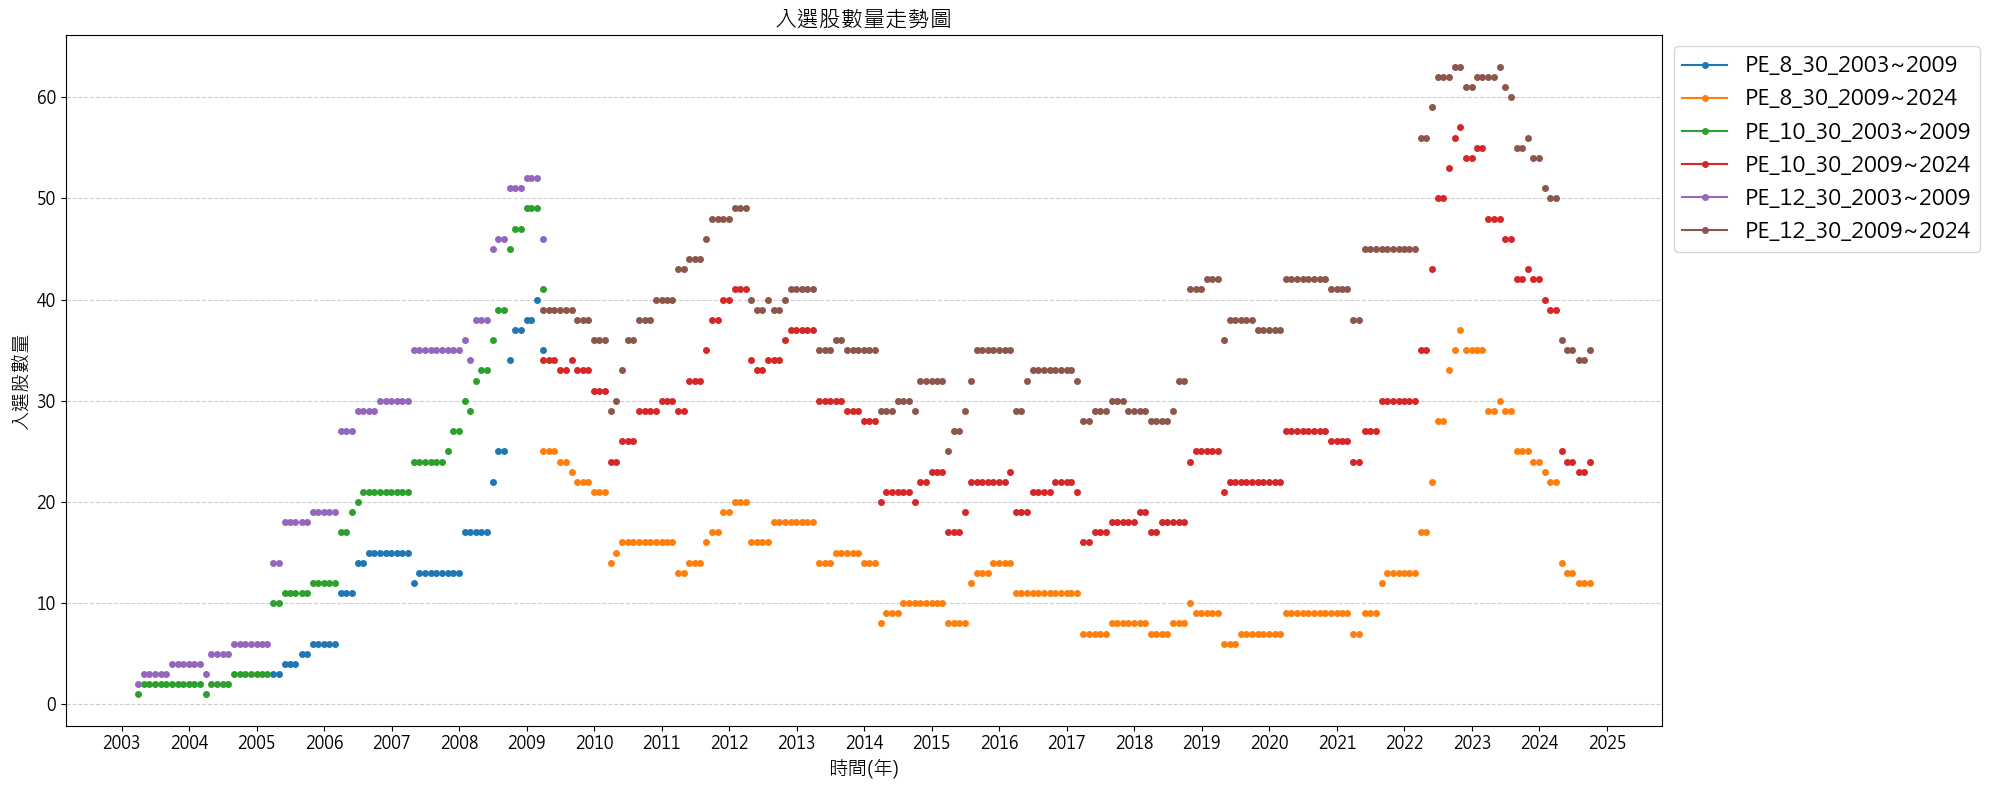

In [54]:
pe_entry_opt_collecs.plot_reps_stock_counts()

### 進出場都最佳化

In [55]:
# pe_opt_strat = {}

# for pe_entries in range(8, 14, 2):
#     for pe_exits in range(24, 32, 2):
#         pe_entry_opt = daily_pe_resample < pe_entries
#         pe_exit_opt = daily_pe_resample > pe_exits
    
#         pe_opt_strat[f"PE_{pe_entries}_{pe_exits}_盈再率<40%"] = (orig_all_opt & pe_entry_opt).hold_until((~orig_all_opt) | pe_exit_opt)
#         # pe_opt_strat[f"PE_{pe_entries}_{pe_exits}_盈再80"] = (orig_all & pe_entry_opt).hold_until((~orig_all) | pe_exit_opt)

# pe_opt_collecs = sim_conditions(pe_opt_strat, resample='M',data=data)

In [56]:
# pe_opt_collecs.plot_stats(mode='heatmap')

---

## 盈再率 + 本益比最佳化

In [57]:
rr_opt_base_conds = roe_15 & payout_ratio_cond & profit_cond & hold_cond & listed
rr_opt_conds = {}

for n in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]:
    rr_opt_all_conds = rr_opt_base_conds & (rr < n)
    rr_opt_conds[f'盈再率<{n}_2003~2009'] = (rr_opt_all_conds[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~rr_opt_all_conds[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])
    rr_opt_conds[f'盈再率<{n}_2009~2024'] = (rr_opt_all_conds['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~rr_opt_all_conds['2009-3':]) | pe_cond_exit_daily['2009-3':])

# rr_opt_conds[f'盈再率>0.8'] = (rr_opt_base_conds & (rr > 0.8) & pe_cond_entry_daily).hold_until((~rr_opt_base_conds) | pe_cond_exit_daily)



rr_opt_collecs = sim_conditions(rr_opt_conds, resample='M', data=data)
# rr_opt_collecs.plot_stats()

Backtesting progress: 100%|██████████| 14/14 [00:33<00:00,  2.43s/condition]


In [58]:
rr_opt_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min   Max
Strategy                                                                  
盈再率<0_2009~2024       15.47   -26.01    8.48   9.0   6.0  11.0   4.0  13.0
盈再率<0.4_2009~2024     14.72   -30.55   39.64  38.0  33.0  43.0  25.0  63.0
盈再率<0.8_2009~2024     14.68   -31.00   47.66  45.0  42.0  49.0  30.0  80.0
盈再率<0.6_2009~2024     14.62   -30.58   45.09  43.0  39.0  47.0  29.0  74.0
盈再率<0.1_2009~2024     14.56   -26.59   18.50  18.0  13.0  22.0   9.0  31.0
盈再率<0.2_2009~2024     13.87   -27.57   26.53  26.0  21.0  29.0  15.0  45.0
盈再率<0.3_2009~2024     13.82   -29.43   33.91  32.0  30.0  37.0  22.0  55.0
盈再率<0.3_2003~2009     12.79   -54.52   20.51  24.0   5.0  33.0   1.0  45.0
盈再率<0.1_2003~2009     12.71   -60.11   10.93  12.0   2.0  19.0   1.0  26.0
盈再率<0.4_2003~2009     11.40   -55.18   23.11  27.0   6.0  35.0   2.0  52.0
盈再率<0_2003~2009       10.39   -60.39    8.46   8.0   4.0  12.0   1.0  16.0
盈再率<0.2_2003~2009      9.67   -60.23   15.58  19.0   3.0  25.0   1.0  33.0
盈再率<0.6_2003~2009      8.76   -54.37   28.97  32.0  10.0  41.0   2.0  65.0
盈再率<0.8_2003~2009      8.25   -53.92   31.04  34.0  11.0  44.0   2.0  69.0

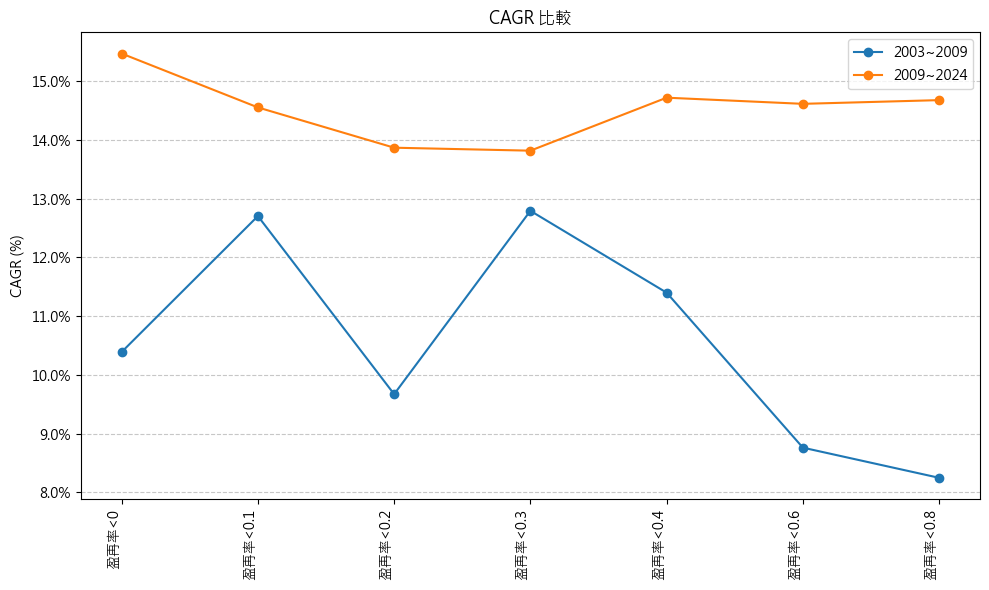

In [137]:
plot_diff_period_cagr(rr_opt_collecs)

In [ ]:
rr_opt_collecs.reports['盈再率<0.1_2003~2009'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    12.71%  45.08      -60.11%     56.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2004-04-01 2009-04-01     2004-03-31    2009-03-31  1.000000    1240   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.083333     743   
2103     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.052632     476   
2401     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.052632     476   
3014     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.038462     122   
3033     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.052632     476   
5203     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.038462      57   
6203     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.045455     186   
6206     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.045455     186   
6281     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.045455     186   
9925     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.058824     249   
9927     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.052632     476   
1723     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2006     2008-07-01        NaT     2008-06-30           NaT  0.045455    3999   
2360     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2365     2006-04-03        NaT     2006-03-31           NaT  0.083333    4556   
2374     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2382     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2397     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2404     2005-04-01        NaT     2005-03-31           NaT  0.200000    4804   
2450     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2495     2007-05-02        NaT     2007-04-30           NaT  0.052632    4289   
2498     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
2536     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
2548     2006-04-03        NaT     2006-03-31           NaT  0.083333    4556   
2606     2005-04-01        NaT     2005-03-31           NaT  0.200000    4804   
3034     2008-04-01        NaT     2008-03-31           NaT  0.058824    4062   
3045     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
3293     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
4904     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
5471     2008-07-01        NaT     2008-06-30           NaT  0.045455    3999   
5508     2007-05-02        NaT     2007-04-30           NaT  0.052632    4289   
5534     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
6188     2009-04-01        NaT     2009-03-31           NaT  0.040000    3813   
6202     2006-11-01        NaT     2006-10-31           NaT  0.071429    4409   
8924     2007-05-02        NaT     2007-04-30           NaT  0.052632    4289   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
1473             1070        2310  -0.410239 -0.487645   0.611431  0.611431   
2029             1567        2310   0.019550 -0.328110   0.530795  0.530795   
2103             1834        2310   0.242643 -0.194130   1.071473  1.071473   
2401             1834        2310  -0.703407 -0.805302   0.471833  0.471833   
3014             2188        2310  -0.007857 -0.340704   0.193973  0.193973   
3033             1834        2310  -0.396491 -0.622382   0.269396  0.269396   
5203             2253        2310   0.044783 -0.063292   0.071730  0.021097   
6203             2124        2310  -0.121833 -0.499395   0.208951  0.208951   
6206             2124        2310  -0.201893 -0.446088   0.

In [60]:
# rr_opt_collecs.reports['盈再率<0.15'].display()

In [61]:
# rr_opt_base_conds = roe_15 & payout_ratio_cond & profit_cond & hold_cond & listed
# pe_entry_cond_opt = daily_pe_resample < 10

# rr_pe_opt_conds = {}

# for n in [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8]:
#     rr_pe_opt_all_conds = rr_opt_base_conds & (rr < n)
#     rr_pe_opt_conds[f'盈再率<{n}_本益比<12進場'] = (rr_pe_opt_all_conds & pe_cond_entry_daily).hold_until((~rr_pe_opt_all_conds) | pe_cond_exit_daily)
#     rr_pe_opt_conds[f'盈再率<{n}_本益比<10進場'] = (rr_pe_opt_all_conds & pe_entry_cond_opt).hold_until((~rr_pe_opt_all_conds) | pe_cond_exit_daily)

# # rr_pe_opt_conds[f'盈再率>0.8'] = (rr_opt_base_conds & (rr > 0.8) & pe_entry_cond_opt).hold_until((~rr_opt_base_conds) | pe_cond_exit_daily)



# rr_pe_opt_collecs = sim_conditions(rr_pe_opt_conds, resample='M', data=data)
# rr_pe_opt_collecs.plot_stats()

In [62]:
# rr_pe_opt_collecs.selected_stock_count_analysis()

In [63]:
# import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_diff_RR_cagr(report_collec, title='CAGR 比較'):
    """
    將策略分為以'PE_10'和'PE_12'結尾的兩個CAGR折線圖，並顯示在同一圖表上

    參數:
    report_collec: 策略報告集合
    title: 圖表標題

    返回: 顯示圖表
    """

    reports = report_collec.reports

    strategies_pe10 = []
    cagr_values_pe10 = []
    strategies_pe12 = []
    cagr_values_pe12 = []

    # 獲得每個策略的CAGR，並根據命名進行分類
    for strategy_name, report in reports.items():
        if strategy_name.endswith('本益比<10進場'):
            prefix = strategy_name.replace('_本益比<10進場', '')
            strategies_pe10.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe10.append(cagr)
        elif strategy_name.endswith('本益比<12進場'):
            prefix = strategy_name.replace('_本益比<12進場', '')
            strategies_pe12.append(prefix)
            cagr = report.get_stats()['CAGR'] * 100
            cagr_values_pe12.append(cagr)

    # 確保兩個列表的長度一致，以保持x軸一致性
    all_prefixes = sorted(list(set(strategies_pe10) | set(strategies_pe12)))

    cagr_values_pe10_aligned = [cagr_values_pe10[strategies_pe10.index(prefix)] if prefix in strategies_pe10 else None for prefix in all_prefixes]
    cagr_values_pe12_aligned = [cagr_values_pe12[strategies_pe12.index(prefix)] if prefix in strategies_pe12 else None for prefix in all_prefixes]

    # 繪製同一張圖上的兩條線
    plt.figure(figsize=(10, 6))

    plt.plot(all_prefixes, cagr_values_pe10_aligned, marker='o', label='PE<10進場', color='tab:blue')
    plt.plot(all_prefixes, cagr_values_pe12_aligned, marker='o', label='PE<12進場', color='tab:orange')

    # 設定圖表標題與軸標籤
    plt.title(title)
    plt.xlabel('盈再率<多少%')
    plt.ylabel('CAGR (%)')
    plt.gca().yaxis.set_major_formatter(PercentFormatter())

    # 設定 x 軸刻度及旋轉角度
    plt.xticks(rotation=0, ha='center', fontsize=12)

    # 添加網格線和圖例
    plt.grid(True, alpha=0.7, axis='y', linestyle='--')
    plt.legend(fontsize=13)

    plt.tight_layout()

    # 顯示圖表
    plt.show()

# plot_diff_RR_cagr(rr_pe_opt_collecs, title='盈再率<多少% CAGR')

In [64]:
# rr_02_pos, rr_02_neg = rr_pe_opt_collecs.reports['盈再率<0.2_本益比<12進場'].calc_returns_contrib()

In [65]:
# rr_0_pos, rr_0_neg = rr_pe_opt_collecs.reports['盈再率<0_本益比<12進場'].calc_returns_contrib()

In [66]:
# rr_pe_opt_collecs.compare_strat_perform('本益比<10進場','本益比<12進場')

In [67]:
# rr_pe_opt_collecs.plot_reps_stock_counts(['盈再率<0.4_本益比<12進場','盈再率<0.1_本益比<12進場','盈再率<0_本益比<12進場'])

---

## 配息率+本益比進場條件參數最佳化

### 本益比 <12 進場

In [159]:
payout_per_opts = {}

for i in range(0, 85, 5):
    for j in range(10, 13, 2):
        payout_ratio_cond_opt = (payout_ratio.rolling(3).min() >= i) #[START_DATE:END_DATE]
        per_entry_opt = daily_pe_resample < j

        opt_payout_PER_cond = (roe_15 & rr_cond & payout_ratio_cond_opt & profit_cond & hold_cond & listed) #[START_DATE:END_DATE]
        # payout_per_opts[f'配息_{i}%_PE_{j}'] = (opt_payout_PER_cond & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond) | pe_cond_exit_daily[START_DATE:END_DATE])

        # payout_per_opts[f'配息三年大於{str(i).rjust(2, "0")}%_2003~2009'] = (opt_payout_PER_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])
        payout_per_opts[f'配息三年大於{str(i).rjust(2, "0")}%'] = (opt_payout_PER_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

        # payout_per_opts[f'配息三年大於{str(i).rjust(2, "0")}%_2009~2024'] = (opt_payout_PER_cond['2009-3':] & per_entry_opt['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | pe_cond_exit_daily['2009-3':])

payout_PER_opts_comb = sim_conditions(payout_per_opts, resample='M', data=data)
# payout_PER_opts_comb.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 17/17 [00:35<00:00,  2.08s/condition]


In [160]:
payout_PER_opts_comb.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  Min   Max
Strategy                                                         
配息三年大於75%     13.98   -55.36    3.18   1.0   1.0   5.0  1.0  10.0
配息三年大於35%     13.05   -55.20   26.47  30.0   8.0  41.0  2.0  57.0
配息三年大於20%     12.92   -55.57   32.53  34.0  15.0  49.0  3.0  64.0
配息三年大於25%     12.76   -55.63   31.10  34.0  13.0  47.0  2.0  63.0
配息三年大於30%     12.20   -54.77   29.52  33.0  11.0  45.0  2.0  60.0
配息三年大於45%     12.07   -55.16   21.01  23.0   5.0  35.0  1.0  50.0
配息三年大於40%     11.79   -55.20   22.85  26.0   6.0  36.0  2.0  52.0
配息三年大於15%     10.87   -55.57   33.75  34.0  19.0  50.0  4.0  64.0
配息三年大於55%     10.80   -56.26   15.64  16.0   4.0  26.0  1.0  41.0
配息三年大於50%     10.71   -55.96   17.92  18.0   4.0  31.0  1.0  45.0
配息三年大於10%     10.41   -56.38   34.82  37.0  20.0  51.0  4.0  65.0
配息三年大於05%     10.32   -56.38   34.89  37.0  20.0  51.0  4.0  65.0
配息三年大於80%      9.74   -60.08    2.08   2.0   1.0   3.0  1.0   4.0
配息三年大於00%      9.30   -57.48   37.00  37.0  23.0  54.0  7.0  68.0
配息三年大於70%      8.39   -50.70    7.03   6.0   4.0   9.0  2.0  17.0
配息三年大於60%      8.24   -55.93   14.72  12.0   7.0  21.0  3.0  37.0
配息三年大於65%      7.95   -52.71   10.43   8.0   5.0  12.0  2.0  29.0

In [70]:
# payout_PER_opts_comb.reports['配息_75%_PE_12'].display()

In [144]:
payout_PER_opts_comb.holding_period_analysis()

CAGR (%)  MDD (%)      持有期間平均     25%    中位數      75%  \
Strategy                                                                     
配息三年大於70%_2009~2024     15.65   -29.15  861.243902  334.25  530.5  1064.00   
配息三年大於65%_2009~2024     15.02   -28.97  828.216216  365.00  517.0  1049.50   
配息三年大於20%_2009~2024     14.74   -31.02  865.975694  365.00  545.0  1096.00   
配息三年大於50%_2009~2024     14.69   -29.94  826.725962  365.00  500.5   920.50   
配息三年大於45%_2009~2024     14.68   -30.55  889.508850  365.00  545.0  1096.75   
配息三年大於80%_2009~2024     14.54   -30.59  779.472222  357.50  532.0   889.75   
配息三年大於35%_2009~2024     14.50   -30.64  896.369650  365.00  548.0  1100.00   
配息三年大於30%_2009~2024     14.50   -30.64  873.985455  365.00  548.0  1096.00   
配息三年大於60%_2009~2024     14.49   -29.67  804.551724  365.00  517.0   913.00   
配息三年大於40%_2009~2024     14.39   -30.55  900.099585  365.00  577.0  1100.00   
配息三年大於55%_2009~2024     14.38   -28.59  817.540541  365.00  517.0   913.00   
配息三年大於25%_2009~2024     14.35   -31.02  870.971530  365.00  547.0  1096.00   
配息三年大於15%_2009~2024     14.19   -31.86  851.833333  365.00  545.0  1064.25   
配息三年大於10%_2009~2024     14.18   -32.25  852.226974  365.00  547.5  1065.00   
配息三年大於75%_2003~2009     13.98   -55.36  416.909091  258.50  365.0   637.50   
配息三年大於05%_2009~2024     13.85   -32.25  860.071661  365.00  548.0  1096.00   
配息三年大於75%_2009~2024     13.85   -25.66  871.000000  365.00  547.0  1080.00   
配息三年大於00%_2009~2024     13.56   -31.91  843.246201  365.00  547.0  1065.00   
配息三年大於35%_2003~2009     13.05   -55.20  713.812500  335.00  685.0  1093.00   
配息三年大於20%_2003~2009     12.92   -55.57  711.161616  335.00  638.0  1093.00   
配息三年大於25%_2003~2009     12.76   -55.63  731.521739  364.00  670.5  1093.00   
配息三年大於30%_2003~2009     12.20   -54.77  742.244186  364.00  699.0  1093.00   
配息三年大於45%_2003~2009     12.07   -55.16  707.515625  356.75  699.0  1093.00   
配息三年大於40%_2003~2009     11.79   -55.20  724.455882  356.75  699.0  1093.00   
配息三年大於15%_2003~2009     10.87   -55.57  703.038462  335.00  529.5  1093.00   
配息三年大於55%_2003~2009     10.80   -56.26  649.807692  327.75  394.0  1043.00   
配息三年大於50%_2003~2009     10.71   -55.96  678.245614  335.00  575.0  1067.00   
配息三年大於10%_2003~2009     10.41   -56.38  705.504673  335.00  575.0  1093.00   
配息三年大於05%_2003~2009     10.32   -56.38  700.092593  327.75  575.0  1093.00   
配息三年大於80%_2003~2009      9.74   -60.08  461.600000  365.00  394.0   575.00   
配息三年大於00%_2003~2009      9.30   -57.48  691.129310  335.00  546.5  1093.00   
配息三年大於70%_2003~2009      8.39   -50.70  606.571429  274.00  365.0   700.00   
配息三年大於60%_2003~2009      8.24   -55.93  601.954545  298.00  379.5   708.00   
配息三年大於65%_2003~2009      7.95   -52.71  553.176471  364.00  365.0   699.75   

                        最大值    最小值  
Strategy                            
配息三年大於70%_2009~2024  5235.0   60.0  
配息三年大於65%_2009~2024  5235.0   90.0  
配息三年大於20%_2009~2024  5235.0   86.0  
配息三年大於50%_2009~2024  5235.0   86.0  
配息三年大於45%_2009~2024  5235.0   86.0  
配息三年大於80%_2009~2024  3957.0   53.0  
配息三年大於35%_2009~2024  5235.0   86.0  
配息三年大於30%_2009~2024  5235.0   86.0  
配息三年大於60%_2009~2024  5235.0   90.0  
配息三年大於40%_2009~2024  5235.0   86.0  
配息三年大於55%_2009~2024  5235.0   86.0  
配息三年大於25%_2009~2024  5235.0   86.0  
配息三年大於15%_2009~2024  5235.0   86.0  
配息三年大於10%_2009~2024  5235.0   32.0  
配息三年大於75%_2003~2009   761.0  148.0  
配息三年大於05%_2009~2024  5235.0   32.0  
配息三年大於75%_2009~2024  3957.0   53.0  
配息三年大於00%_2009~2024  5235.0   32.0  
配息三年大於35%_2003~2009  2192.0   60.0  
配息三年大於20%_2003~2009  2192.0   29.0  
配息三年大於25%_2003~2009  2192.0   60.0  
配息三年大於30%_2003~2009  2192.0   60.0  
配息三年大於45%_2003~2009  2100.0   85.0  
配息三年大於40%_2003~2009  2192.0   85.0  
配息三年大於15%_2003~2009  2192.0   29.0  
配息三年大於55%_2003~2009  1826.0   85.0  
配息三年大於50%_2003~2009  2100.0   85.0  
配息三年大於10%_2003~2009  2192.0   29.0  
配息三年大於05%_2003~2009  2192.0   29.0  
配息三年大於80%_2003~2009   700.0  274.0  
配息三年大於00%_2003~2009  2192.0 

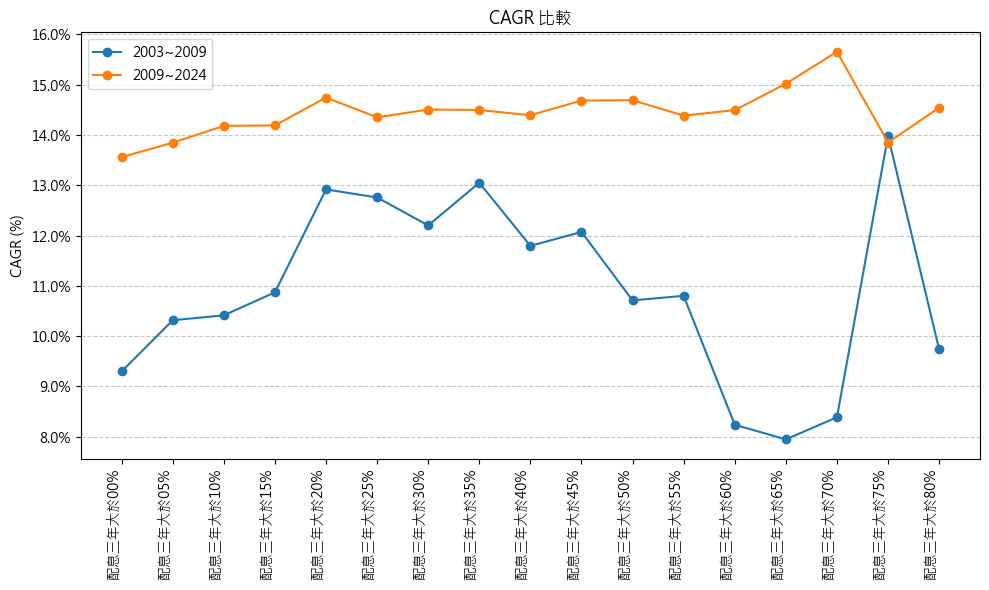

In [145]:
plot_diff_period_cagr(payout_PER_opts_comb)

In [162]:
# payout_PER_opts_comb.plot_reps_stock_counts(['配息三年大於45%'])

In [156]:
# payout_PER_opts_comb.reports['配息三年大於75%_2003~2009'].calc_returns_contrib()

## 盈再率 + 配息率最佳化

In [229]:
rr_dpr_opt_base_conds = roe_15 & profit_cond & hold_cond & listed
pe_entry_cond_opt = daily_pe_resample < 10

rr_dpr_pe_opt_conds = {}

for i in range(0, 76, 5): 
    for n in [0, 0.2, 0.4]: #, 0.6, 0.8]:
        dpr_cond_rr_opt = (payout_ratio.rolling(3).min() >= i) #[START_DATE:END_DATE]
        rr_dpr_opt_all_conds = (rr_dpr_opt_base_conds & (rr < n) & dpr_cond_rr_opt)
        
        # rr_dpr_pe_opt_conds[f'盈再率<{n}_本益比<12進場'] = (rr_dpr_opt_all_conds & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~rr_dpr_opt_all_conds) | pe_cond_exit_daily[START_DATE:END_DATE])
        # rr_dpr_pe_opt_conds[f'盈再率<{n}_配息率{i}%_本益比<10'] = (rr_dpr_opt_all_conds[START_DATE:END_DATE] & pe_entry_cond_opt[START_DATE:END_DATE]).hold_until((~rr_dpr_opt_all_conds[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

        # rr_dpr_pe_opt_conds[f'盈再率<{n}_配息率_{i}_2003~2009'] = (rr_dpr_opt_all_conds[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~rr_dpr_opt_all_conds[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])
        rr_dpr_pe_opt_conds[f'盈再率<{n}_配息率_{i}'] = (rr_dpr_opt_all_conds[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~rr_dpr_opt_all_conds[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

        # rr_dpr_pe_opt_conds[f'盈再率<{n}_配息率_{i}_2009~2024'] = (rr_dpr_opt_all_conds['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~rr_dpr_opt_all_conds['2009-3':]) | pe_cond_exit_daily['2009-3':])
        # rr_dpr_pe_opt_conds[f'盈再率<{n}_配息率_{i}'] = (rr_dpr_opt_all_conds['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~rr_dpr_opt_all_conds['2009-3':]) | pe_cond_exit_daily['2009-3':])

# rr_pe_opt_conds[f'盈再率>0.8'] = (rr_opt_base_conds & (rr > 0.8) & pe_entry_cond_opt).hold_until((~rr_opt_base_conds) | pe_cond_exit_daily)



rr_dpr_pe_opt_collecs = sim_conditions(rr_dpr_pe_opt_conds, resample='M', data=data)
# rr_dpr_pe_opt_collecs.plot_stats()

Backtesting progress: 100%|██████████| 48/48 [01:02<00:00,  1.31s/condition]


In [251]:
df = rr_dpr_pe_opt_collecs.selected_stock_count_analysis()
# 顯示dataframe當中 Min column 最小 > 0 的資料
df

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  Min   Max
Strategy                                                              
盈再率<0.2_配息率_25     14.60   -59.29   20.36  24.0   7.0  32.0  1.0  38.0
盈再率<0.2_配息率_20     14.36   -59.08   20.68  24.0   7.0  33.0  1.0  39.0
盈再率<0_配息率_30       14.10   -61.16    9.57   9.0   5.0  14.0  1.0  17.0
盈再率<0_配息率_25       14.07   -61.16    9.77   9.0   5.0  15.0  1.0  17.0
盈再率<0.4_配息率_75     13.54   -59.97    2.94   1.0   1.0   4.0  1.0  10.0
盈再率<0_配息率_35       13.52   -61.59    9.32   9.0   5.0  13.0  1.0  17.0
盈再率<0.2_配息率_30     13.51   -59.29   19.42  23.0   6.0  30.0  1.0  38.0
盈再率<0_配息率_55       13.40   -61.02    6.09   5.0   2.0   9.0  1.0  14.0
盈再率<0_配息率_5        13.27   -60.66   10.18   9.0   5.0  16.0  1.0  18.0
盈再率<0_配息率_10       13.27   -60.66   10.18   9.0   5.0  16.0  1.0  18.0
盈再率<0_配息率_15       13.27   -60.66   10.18   9.0   5.0  16.0  1.0  18.0
盈再率<0_配息率_20       13.27   -60.66   10.18   9.0   5.0  16.0  1.0  18.0
盈再率<0.2_配息率_15     13.26   -59.08   21.21  24.0  10.0  33.0  1.0  39.0
盈再率<0.2_配息率_10     12.70   -60.23   21.53  24.0  10.0  33.0  1.0  40.0
盈再率<0.2_配息率_0      12.67   -61.36   23.08  25.0  10.0  36.0  2.0  43.0
盈再率<0.2_配息率_75     12.53   -65.75    2.27   1.0   1.0   3.0  1.0   6.0
盈再率<0_配息率_0        12.49   -62.09   10.88  10.0   5.0  17.0  1.0  19.0
盈再率<0.2_配息率_5      12.42   -60.23   21.59  24.0  10.0  33.0  1.0  40.0
盈再率<0.4_配息率_35     11.99   -55.38   26.67  30.0   8.0  40.0  2.0  57.0
盈再率<0.2_配息率_35     11.95   -59.48   17.62  20.0   5.0  28.0  1.0  37.0
盈再率<0.4_配息率_45     11.89   -55.21   21.29  24.0   5.0  34.0  1.0  50.0
盈再率<0.4_配息率_25     11.59   -55.76   31.37  34.0  13.0  46.0  2.0  63.0
盈再率<0_配息率_50       11.45   -60.61    7.36   7.0   3.0  10.0  1.0  15.0
盈再率<0.4_配息率_20     11.43   -55.69   32.84  34.0  15.0  48.0  3.0  64.0
盈再率<0.4_配息率_30     11.40   -54.88   29.75  33.0  11.0  44.0  2.0  60.0
盈再率<0.4_配息率_40     11.40   -55.18   23.11  27.0   6.0  35.0  2.0  52.0
盈再率<0_配息率_45       10.63   -60.39    7.80   7.0   3.0  11.0  1.0  16.0
盈再率<0.4_配息率_50     10.54   -55.90   18.27  19.0   4.0  30.0  1.0  45.0
盈再率<0_配息率_40       10.39   -60.39    8.46   8.0   4.0  12.0  1.0  16.0
盈再率<0.2_配息率_45     10.28   -60.86   14.51  17.0   3.0  24.0  1.0  31.0
盈再率<0.2_配息率_50     10.24   -59.19   12.92  14.0   3.0  21.0  1.0  30.0
盈再率<0.4_配息率_15      9.91   -55.69   33.85  34.0  19.0  49.0  4.0  64.0
盈再率<0.4_配息率_55      9.82   -56.23   15.99  17.0   4.0  25.0  1.0  41.0
盈再率<0.2_配息率_40      9.67   -60.23   15.58  19.0   3.0  25.0  1.0  33.0
盈再率<0.4_配息率_10      9.52   -56.49   35.37  38.0  20.0  51.0  4.0  65.0
盈再率<0.4_配息率_5       9.43   -56.49   35.44  38.0  20.0  51.0  4.0  65.0
盈再率<0.2_配息率_55      9.17   -60.21   11.12  12.0   3.0  18.0  1.0  27.0
盈再率<0.4_配息率_70      8.43   -51.36    6.93   6.0   4.0   8.0  2.0  17.0
盈再率<0.4_配息率_0       8.42   -57.59   37.56  38.0  23.0  54.0  7.0  68.0
盈再率<0.4_配息率_65      7.84   -53.18   10.31   8.0   5.0  11.0  2.0  29.0
盈再率<0.4_配息率_60      7.59   -56.17   14.75  12.0   7.0  20.0  3.0  37.0
盈再率<0.2_配息率_70      7.25   -57.50    5.36   5.0   3.0   6.0  2.0  12.0
盈再率<0.2_配息率_65      6.70   -57.59    7.67   6.0   4.0   8.0  2.0  21.0
盈再率<0_配息率_70        6.37   -60.42    3.59   3.0   3.0   4.0  1.0   7.0
盈再率<0_配息率_65        5.30   -60.95    5.29   4.0   4.0   6.0  1.0  12.0
盈再率<0.2_配息率_60      4.38   -61.45    9.92   9.0   5.0  14.0  2.0  24.0
盈再率<0_配息率_60        3.84   -60.95    5.49   4.0   4.0   7.0  1.0  12.0
盈再率<0_配息率_75        1.13   -66.92    2.75   2.0   2.0   4.0  2.0   4.0

In [231]:
# rr_dpr_pe_opt_collecs.reports['盈再率<0.2_配息率_50_2003~2009'].display()

In [232]:
df.index

Index(['盈再率<0.2_配息率_25', '盈再率<0.2_配息率_20', '盈再率<0_配息率_30', '盈再率<0_配息率_25',
       '盈再率<0.4_配息率_75', '盈再率<0_配息率_35', '盈再率<0.2_配息率_30', '盈再率<0_配息率_55',
       '盈再率<0_配息率_5', '盈再率<0_配息率_10', '盈再率<0_配息率_15', '盈再率<0_配息率_20',
       '盈再率<0.2_配息率_15', '盈再率<0.2_配息率_10', '盈再率<0.2_配息率_0', '盈再率<0.2_配息率_75',
       '盈再率<0_配息率_0', '盈再率<0.2_配息率_5', '盈再率<0.4_配息率_35', '盈再率<0.2_配息率_35',
       '盈再率<0.4_配息率_45', '盈再率<0.4_配息率_25', '盈再率<0_配息率_50', '盈再率<0.4_配息率_20',
       '盈再率<0.4_配息率_30', '盈再率<0.4_配息率_40', '盈再率<0_配息率_45', '盈再率<0.4_配息率_50',
       '盈再率<0_配息率_40', '盈再率<0.2_配息率_45', '盈再率<0.2_配息率_50', '盈再率<0.4_配息率_15',
       '盈再率<0.4_配息率_55', '盈再率<0.2_配息率_40', '盈再率<0.4_配息率_10', '盈再率<0.4_配息率_5',
       '盈再率<0.2_配息率_55', '盈再率<0.4_配息率_70', '盈再率<0.4_配息率_0', '盈再率<0.4_配息率_65',
       '盈再率<0.4_配息率_60', '盈再率<0.2_配息率_70', '盈再率<0.2_配息率_65', '盈再率<0_配息率_70',
       '盈再率<0_配息率_65', '盈再率<0.2_配息率_60', '盈再率<0_配息率_60', '盈再率<0_配息率_75'],
      dtype='object', name='Strategy')

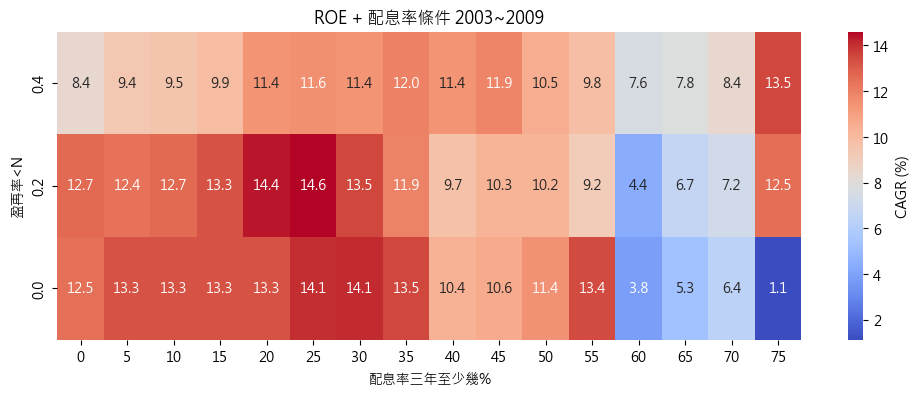

In [256]:
# import numpy as np
import seaborn as sns


# Extracting 'N' and 'X' values manually based on the format "盈再率<N_配息率_X"
df['N'] = df.index.map(lambda x: x.split('<')[1].split('_')[0])  # Extracting 盈再率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])               # Extracting 配息率 (X)

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with 配息率 (X) as columns and 盈再率 (N) as rows
heatmap_data = df.pivot(index="N", columns="X", values="CAGR (%)").sort_index(ascending=False)

# Plotting the heatmap with reversed Y-axis
plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'CAGR (%)'}, yticklabels=heatmap_data.index[:])
plt.xlabel("配息率三年至少幾%")
plt.ylabel("盈再率<N")
plt.title("ROE + 配息率條件 2003~2009")
plt.show()

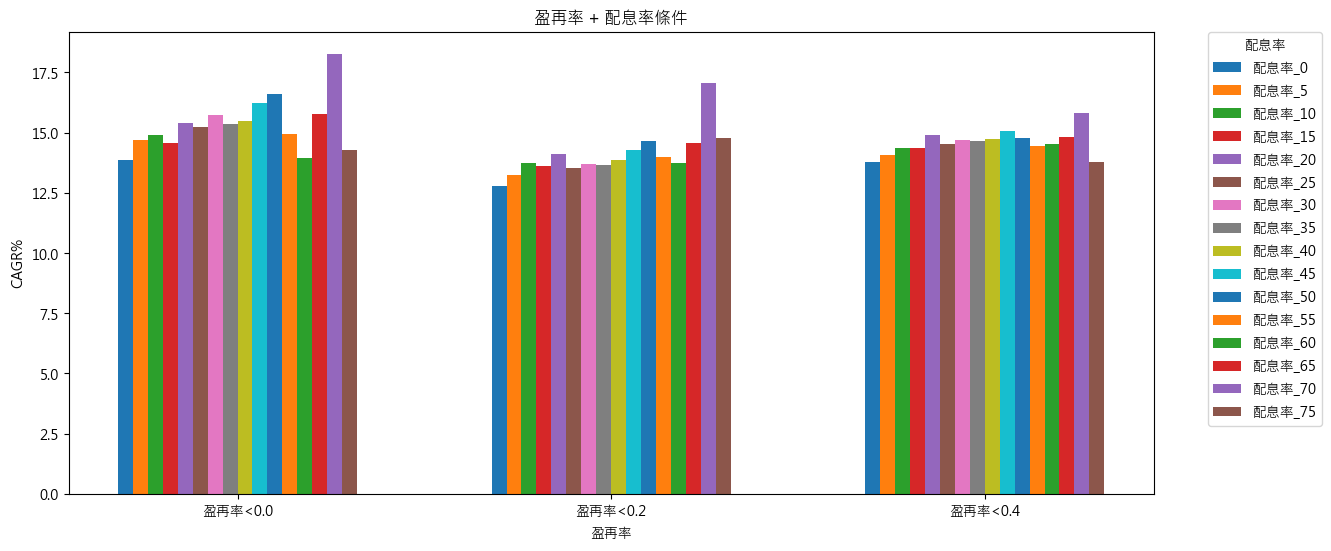

In [192]:
# Extracting 'N' and 'X' values manually
df['N'] = df.index.map(lambda x: x.split('<')[1].split('_')[0])
df['X'] = df.index.map(lambda x: x.split('_')[-1])

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Sorting values for correct order
df.sort_values(by=['N', 'X'], inplace=True)

# Unique values for grouping and bar placement
unique_n_values = sorted(df['N'].unique())
unique_x_values = sorted(df['X'].unique())

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.04  # Width for each bar within a group

# Plot each 'X' value as a separate set of bars within each 'N' group
for i, x_value in enumerate(unique_x_values):
    # Selecting data for specific '配息率 (X)' value within each 'N' group
    bar_positions = [pos + i * bar_width for pos in range(len(unique_n_values))]
    cagr_values = [df[(df['N'] == n_value) & (df['X'] == x_value)]['CAGR (%)'].values[0]
                   if ((df['N'] == n_value) & (df['X'] == x_value)).any() else 0
                   for n_value in unique_n_values]
    
    # Plot bars
    ax.bar(bar_positions, cagr_values, width=bar_width, label=f'配息率_{x_value}')

# Customizing x-axis with '盈再率<N' labels
ax.set_xticks([pos + (bar_width * (len(unique_x_values) - 1) / 2) for pos in range(len(unique_n_values))])
ax.set_xticklabels([f'盈再率<{n}' for n in unique_n_values])

# Adding labels, title, and moving legend outside the plot area
plt.xlabel("盈再率")
plt.ylabel("CAGR%")
plt.title("盈再率 + 配息率條件")
plt.legend(title="配息率", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Display plot
plt.show()

In [77]:
count_filter = df[(df['Min'] > 0) & (df['Max'] < 30)].index.tolist()

In [78]:
period_df = rr_dpr_pe_opt_collecs.holding_period_analysis()
period_df.loc[count_filter]

CAGR (%)  MDD (%)      持有期間平均     25%    中位數     75%   最大值  \
Strategy                                                                        
盈再率<0.2_2009~2024     14.07   -30.59  776.852941  362.75  532.0  905.25  3986   
盈再率<0.4_2009~2024     12.62   -30.59  770.500000  342.50  516.5  845.25  3986   
盈再率<0_2009~2024       11.95   -30.22  785.750000  357.25  685.0  771.75  3286   
盈再率<0.2_2003~2009     11.23   -69.15  433.250000  342.25  379.5  470.50   700   
盈再率<0.4_2003~2009      9.53   -68.04  376.200000  274.00  365.0  394.00   700   
盈再率<0_2003~2009       -8.67   -69.15  446.333333  319.50  365.0  532.50   700   

                   最小值  
Strategy                
盈再率<0.2_2009~2024  121  
盈再率<0.4_2009~2024  121  
盈再率<0_2009~2024    121  
盈再率<0.2_2003~2009  274  
盈再率<0.4_2003~2009  148  
盈再率<0_2003~2009    274

## 本益比平均

#### 先取每個月平均之後再rolling **36個月(三年)平均**

In [79]:
daily_pe = data.get('price:daily_pe')
daily_pe_resample = daily_pe.resample('M').mean()
pe_rol_mean = daily_pe_resample.rolling(36).mean() #[START_DATE:END_DATE]

### 只有進場本益比取三年平均

In [ ]:
pe_entry_rol_strats = {}

for pe_entries in range(8, 14, 2):
    # for pe_exits in range(24, 32, 2):
    pe_entry_opt_strat = pe_rol_mean < pe_entries
    pe_exit_opt_strat = daily_pe_resample > 30

    pe_entry_rol_strats[f"本益比平均_{str(pe_entries).rjust(2, '0')}進場_2003~2009"] = (orig_all_opt[START_DATE:END_DATE] & pe_entry_opt_strat[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_exit_opt_strat[START_DATE:END_DATE])
    pe_entry_rol_strats[f"本益比平均_{str(pe_entries).rjust(2, '0')}進場_2009~2024"] = (orig_all_opt['2009-3':] & pe_entry_opt_strat['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_exit_opt_strat['2009-3':])
        # pe_entry_rol_strats[f"本益比平均_{pe_entries}_{pe_exits} + 盈再80"] = (orig_all & pe_entry_opt_strat).hold_until((~orig_all) | pe_exit_opt_strat)


# pe_entry_rol_strats['原始條件_本益比進出場_2003~2009'] = orig_all_opt_pe_daily
# pe_entry_rol_strats['原始條件_本益比進出場_2009~2024'] = (orig_all_opt['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':])

In [266]:
pe_entry_rol_strats_collec = sim_conditions(pe_entry_rol_strats, resample='M', data=data)
# pe_entry_rol_strats_collec.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 3/3 [00:06<00:00,  2.19s/condition]


In [226]:
pe_entry_rol_strats_collec.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min   Max
Strategy                                                                      
本益比平均_10進場_2009~2024      15.72   -30.88   10.45  11.0   7.0  14.0   3.0  17.0
本益比平均_12進場_2009~2024      14.74   -31.46   24.18  25.0  19.0  28.0  15.0  37.0
原始條件_本益比進出場_2009~2024     14.72   -30.55   39.64  38.0  33.0  43.0  25.0  63.0
本益比平均_08進場_2003~2009      12.59   -60.45    3.35   4.0   1.0   5.0   1.0   5.0
本益比平均_08進場_2009~2024      11.79   -35.75    2.70   2.0   1.0   4.0   0.0   7.0
原始條件_本益比進出場_2003~2009     11.40   -55.18   23.11  27.0   6.0  35.0   2.0  52.0
本益比平均_12進場_2003~2009       8.65   -56.57   15.81  17.0   4.0  28.0   2.0  32.0
本益比平均_10進場_2003~2009       6.04   -58.04   13.51  13.0   7.0  22.0   1.0  24.0

In [83]:
# pe_entry_rol_strats_collec.compare_strat_perform('+ 盈再40', '+ 盈再80')

In [130]:
pe_entry_rol_strats_collec.holding_period_analysis()

CAGR (%)  MDD (%)      持有期間平均     25%    中位數      75%  \
Strategy                                                                      
本益比平均_10進場_2009~2024     15.72   -30.88  870.544118  365.00  610.5  1141.25   
本益比平均_12進場_2009~2024     14.74   -31.46  919.087248  365.00  699.0  1097.00   
本益比平均_08進場_2003~2009     12.59   -60.45  735.200000  699.00  700.0   729.00   
本益比平均_08進場_2009~2024     11.79   -35.75  850.944444  395.00  609.0  1012.00   
本益比平均_12進場_2003~2009      8.65   -56.57  776.840909  365.75  700.0  1093.00   
本益比平均_10進場_2003~2009      6.04   -58.04  673.655172  425.00  699.0   881.00   

                       最大值  最小值  
Strategy                         
本益比平均_10進場_2009~2024  4169   33  
本益比平均_12進場_2009~2024  5296   31  
本益比平均_08進場_2003~2009  1094  454  
本益比平均_08進場_2009~2024  3439   91  
本益比平均_12進場_2003~2009  2192   85  
本益比平均_10進場_2003~2009  1307   29

In [113]:
df_mean_pe = pe_entry_rol_strats_collec.holding_period_analysis()
df_mean_pe = df_mean_pe.sort_index()

In [114]:
df_mean_pe

CAGR (%)  MDD (%)      持有期間平均     25%    中位數      75%  \
Strategy                                                                      
本益比平均_10進場_2003~2009      6.04   -58.04  673.655172  425.00  699.0   881.00   
本益比平均_10進場_2009~2024     15.72   -30.88  870.544118  365.00  610.5  1141.25   
本益比平均_12進場_2003~2009      8.65   -56.57  776.840909  365.75  700.0  1093.00   
本益比平均_12進場_2009~2024     14.74   -31.46  919.087248  365.00  699.0  1097.00   
本益比平均_8進場_2003~2009      12.59   -60.45  735.200000  699.00  700.0   729.00   
本益比平均_8進場_2009~2024      11.79   -35.75  850.944444  395.00  609.0  1012.00   

                       最大值  最小值  
Strategy                         
本益比平均_10進場_2003~2009  1307   29  
本益比平均_10進場_2009~2024  4169   33  
本益比平均_12進場_2003~2009  2192   85  
本益比平均_12進場_2009~2024  5296   31  
本益比平均_8進場_2003~2009   1094  454  
本益比平均_8進場_2009~2024   3439   91

In [116]:
pe_entry_rol_strats_collec.reports.items()

dict_items([('本益比平均_8進場_2003~2009', <report.Report object at 0x000002CB21D6DF50>), ('本益比平均_8進場_2009~2024', <report.Report object at 0x000002CB1E4E5DD0>), ('本益比平均_10進場_2003~2009', <report.Report object at 0x000002CB1E4E4C10>), ('本益比平均_10進場_2009~2024', <report.Report object at 0x000002CB1E576D10>), ('本益比平均_12進場_2003~2009', <report.Report object at 0x000002CB23455350>), ('本益比平均_12進場_2009~2024', <report.Report object at 0x000002CB1E4E4DD0>)])

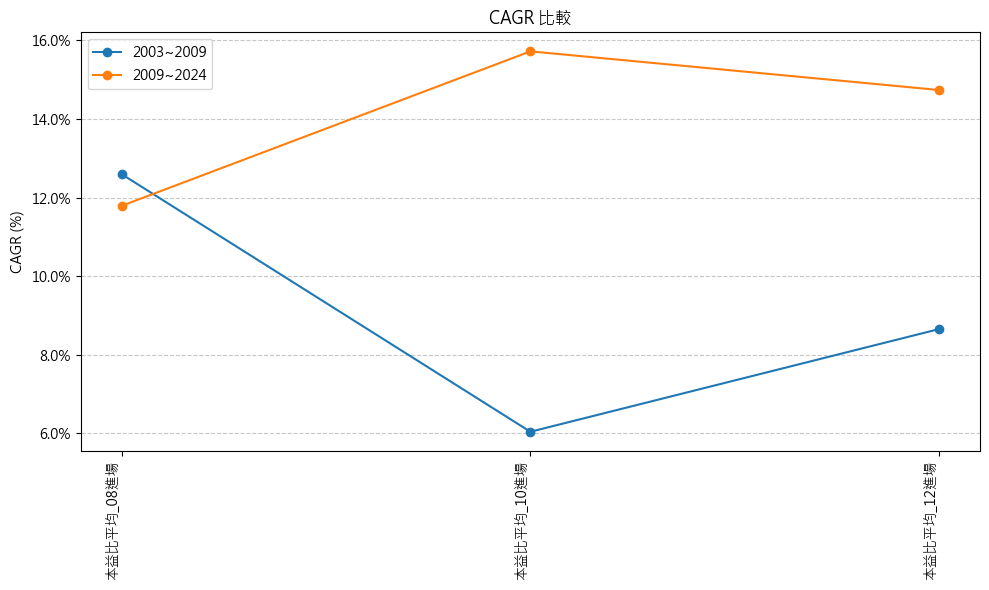

In [131]:
plot_diff_period_cagr(pe_entry_rol_strats_collec)

In [85]:
# pe_entry_rol_strats_collec.reports['本益比平均_10進場_盈再率<40%'].display()

---

### 進場本益比平均三年<10

In [86]:
pe_rol_entry = pe_rol_mean < 10
# pe_rol_exit = pe_rol_mean > 30

#### 盈再率 < 40%

In [ ]:
# # 盈再率 < 40% + 本益比平均 < 10
# pe_rol_entry = pe_rol_mean < 12
pe10_rol_opt = (orig_all_opt[START_DATE:END_DATE] & pe_rol_entry[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

rep_pe_rol_opt = backtest.sim(pe10_rol_opt, resample='M', data=data)
rep_pe_rol_opt.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     8.66%  53.81      -56.57%     50.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     249   
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.500000    1491   
1477     2006-02-03 2009-04-01     2006-01-25    2009-03-31  0.083333     783   
2002     2005-06-01 2009-04-01     2005-05-31    2009-03-31  0.125000     950   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.037037     476   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.058824     743   
3033     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.037037     476   
6281     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.031250      57   
9925     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.035714     249   
9927     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.037037     476   
1301     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
1710     2006-07-03        NaT     2006-06-30           NaT  0.055556    4494   
1723     2003-05-02        NaT     2003-04-30           NaT  0.333333    5282   
2006     2008-04-01        NaT     2008-03-31           NaT  0.035714    4062   
2103     2007-05-02        NaT     2007-04-30           NaT  0.037037    4289   
2365     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
2374     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
2382     2009-01-05        NaT     2008-12-31           NaT  0.031250    3870   
2404     2005-07-01        NaT     2005-06-30           NaT  0.111111    4741   
2495     2007-05-02        NaT     2007-04-30           NaT  0.037037    4289   
2536     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
2548     2007-06-01        NaT     2007-05-31           NaT  0.035714    4267   
2606     2006-09-01        NaT     2006-08-31           NaT  0.052632    4450   
3010     2007-05-02        NaT     2007-04-30           NaT  0.037037    4289   
3015     2008-04-01        NaT     2008-03-31           NaT  0.035714    4062   
3026     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
3034     2009-01-05        NaT     2008-12-31           NaT  0.031250    3870   
4904     2007-09-03        NaT     2007-08-31           NaT  0.034483    4202   
5347     2008-11-03        NaT     2008-10-31           NaT  0.034483    3913   
5471     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
5508     2007-05-02        NaT     2007-04-30           NaT  0.037037    4289   
5534     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
6115     2009-04-01        NaT     2009-03-31           NaT  0.035714    3813   
6139     2007-02-01        NaT     2007-01-31           NaT  0.045455    4344   
6188     2007-05-02        NaT     2007-04-30           NaT  0.037037    4289   
6202     2006-11-01        NaT     2006-10-31           NaT  0.047619    4409   
8924     2005-12-01        NaT     2005-11-30           NaT  0.090909    4636   
9930     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
1303             2061        2310  -0.411847 -0.522974   0.043362  0.043362   
1473              819        2310  -0.259782 -0.358219   1.018494  1.018494   
1477             1527        2310   0.025357 -0.337411   1.781442  1.781442   
2002             1360        2310   0.296122 -0.070732   1.796384  0.195342   
2027             1834        2310  -0.643627 -0.745723   0.103093  0.103093   
2029             1567        2310   0.019550 -0.328110   0.530795  0.530795   
3033             1834        2310  -0.396491 -0.622382   0.269396  0.269396   
6281             2253        2310   0.248979 -0.015440   

In [88]:
# pe_rol_pos_ret, pe_rol_neg_ret = rep_pe_rol_opt.calc_returns_contrib()

#### 盈再率<80%

In [89]:
# # 盈再率 < 80% + 本益比平均 < 12

# pe10_rol = (orig_all & pe_rol_entry).hold_until((~orig_all) | pe_cond_exit_daily)

# rep_pe_rol = backtest.sim(pe10_rol, resample='M', data=data)
# rep_pe_rol.display()

In [90]:
# pe_rol_pos_orig, pe_rol_neg_orig = rep_pe_rol.calc_returns_contrib()

In [91]:
# daily_pe_resample[['3078']].to_csv('./test_csv_file/3078_pe.csv')

### 本益比平均 - 綜合比較

In [92]:
pe_rol_conds = {}

pe_rol_conds['原始條件_盈再率<40%'] = orig_all_opt_pe_daily
pe_rol_conds['本益比平均<10_盈再率<40%'] = pe10_rol_opt
# pe_rol_conds['本益比平均<10_盈再率<80%'] = pe10_rol

pe_rol_entry_orig = (pe_rol_mean < 12)[START_DATE:END_DATE]
pe_rol_conds['本益比平均<12_盈再率<40%'] = (orig_all_opt[START_DATE:END_DATE] & pe_rol_entry_orig[START_DATE:END_DATE]).hold_until((~orig_all_opt[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])
# pe_rol_conds['本益比平均<12_盈再率<80%'] = (orig_all & pe_rol_entry_orig).hold_until((~orig_all) | pe_cond_exit_daily)


pe_rol_conds_collec = sim_conditions(pe_rol_conds, resample='M', data=data)
pe_rol_conds_collec.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 3/3 [00:04<00:00,  1.54s/condition]


In [93]:
pe_rol_conds_collec.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數  25%   75%  Min   Max
Strategy                                                               
原始條件_盈再率<40%         11.40   -55.18   23.11  27.0  6.0  35.0  2.0  52.0
本益比平均<12_盈再率<40%      8.66   -56.57   15.77  17.0  4.0  28.0  2.0  32.0
本益比平均<10_盈再率<40%      5.99   -58.11   13.47  13.0  7.0  22.0  1.0  24.0

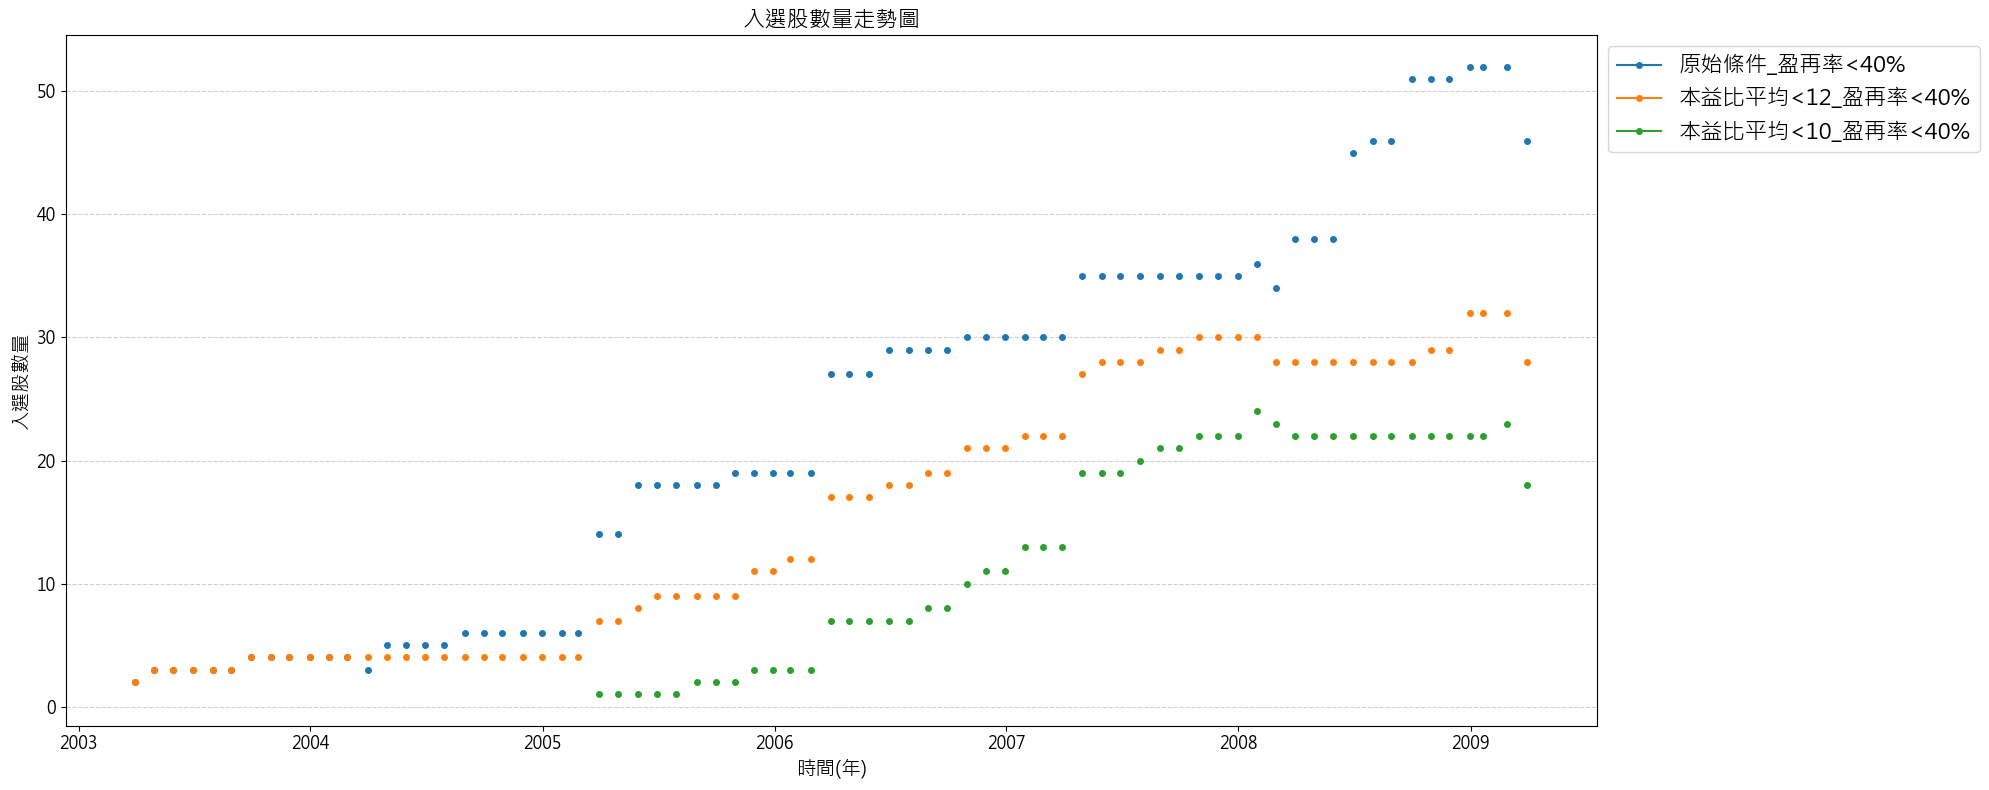

In [94]:
pe_rol_conds_collec.plot_reps_stock_counts(['原始條件_盈再率<40%', '本益比平均<12_盈再率<40%', '本益比平均<10_盈再率<40%',])

---

## 綜合比較 (暫存)

In [ ]:
overall_combs = {}

overall_combs['原始條件+PE<12進場_2003~2009'] = orig_all_opt_pe_daily
overall_combs['原始條件+PE<12進場+ROE<15出場_2003~2009'] = orig_all_opt_pe_roe
overall_combs['原始條件+PE<10進場_2003~2009'] = lower_rr_opt_pe
overall_combs['原始條件+PE<10進場+ROE<15出場_2003~2009'] = lower_roe_pe_cond
overall_combs['原始條件+PE<08進場_2003~2009'] = lower_pe_cond
# overall_combs['原始條件+PE<8進場+ROE<15出場_2003~2009'] = lower_roe_pe_opt

overall_combs['原始條件+PE<12進場_2009~2024'] = (orig_all_opt['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':])
overall_combs['原始條件+PE<12進場+ROE<15出場_2009~2024'] = (orig_all_opt['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':] | (roe['2009-3':] < 15))
overall_combs['原始條件+PE<10進場_2009~2024'] = (orig_all_opt['2009-3':] & (daily_pe_resample < 10)['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':])
overall_combs['原始條件+PE<10進場+ROE<15出場_2009~2024'] = (orig_all_opt['2009-3':] & (daily_pe_resample < 10)['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':] | (roe['2009-3':] < 15))
overall_combs['原始條件+PE<08進場_2009~2024'] = (orig_all_opt['2009-3':] & (daily_pe_resample < 8)['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':])
# overall_combs['原始條件+PE<8進場+ROE<15出場_2009~2024'] = (orig_all_opt['2009-3':] & (daily_pe_resample < 8)['2009-3':]).hold_until((~orig_all_opt['2009-3':]) | pe_cond_exit_daily['2009-3':] | (roe['2009-3':] < 15)


over_rep_collecs = sim_conditions(overall_combs, resample='M', data=data)
# over_rep_collecs.plot_stats(mode='heatmap')

Backtesting progress: 100%|██████████| 6/6 [00:04<00:00,  1.48condition/s]


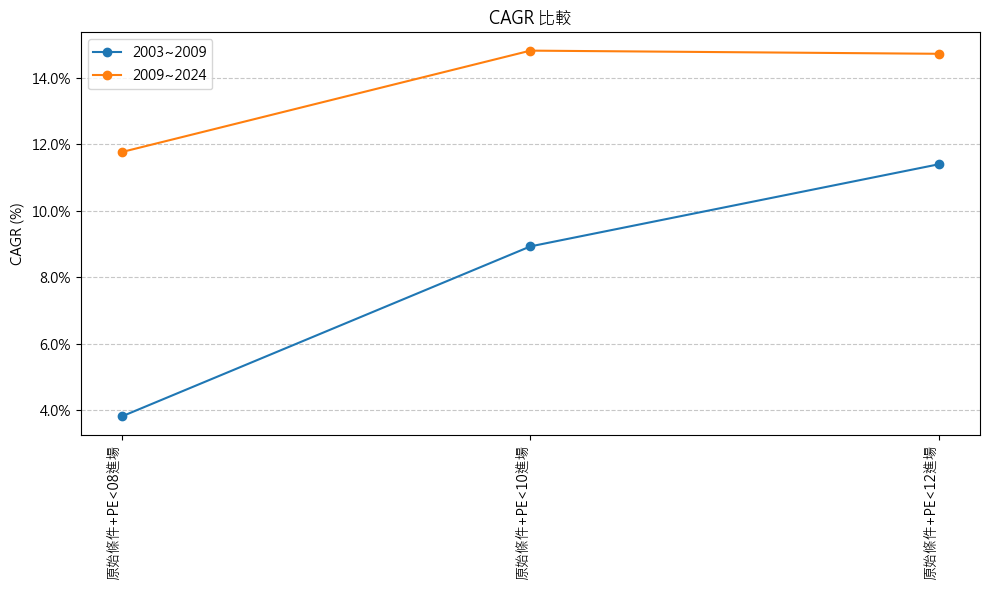

In [135]:
plot_diff_period_cagr(over_rep_collecs)

In [136]:
over_rep_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min  \
Strategy                                                                    
原始條件+PE<10進場_2009~2024     14.82   -33.21   27.89  25.0  21.0  32.5  15.0   
原始條件+PE<12進場_2009~2024     14.72   -30.55   39.64  38.0  33.0  43.0  25.0   
原始條件+PE<08進場_2009~2024     11.76   -39.43   14.57  13.0   8.0  19.0   5.0   
原始條件+PE<12進場_2003~2009     11.40   -55.18   23.11  27.0   6.0  35.0   2.0   
原始條件+PE<10進場_2003~2009      8.93   -56.27   17.41  17.0   3.0  24.0   1.0   
原始條件+PE<08進場_2003~2009      3.81   -57.97   15.73  14.0  11.0  17.0   3.0   

                         Max  
Strategy                      
原始條件+PE<10進場_2009~2024  56.0  
原始條件+PE<12進場_2009~2024  63.0  
原始條件+PE<08進場_2009~2024  37.0  
原始條件+PE<12進場_2003~2009  52.0  
原始條件+PE<10進場_2003~2009  49.0  
原始條件+PE<08進場_2003~2009  40.0

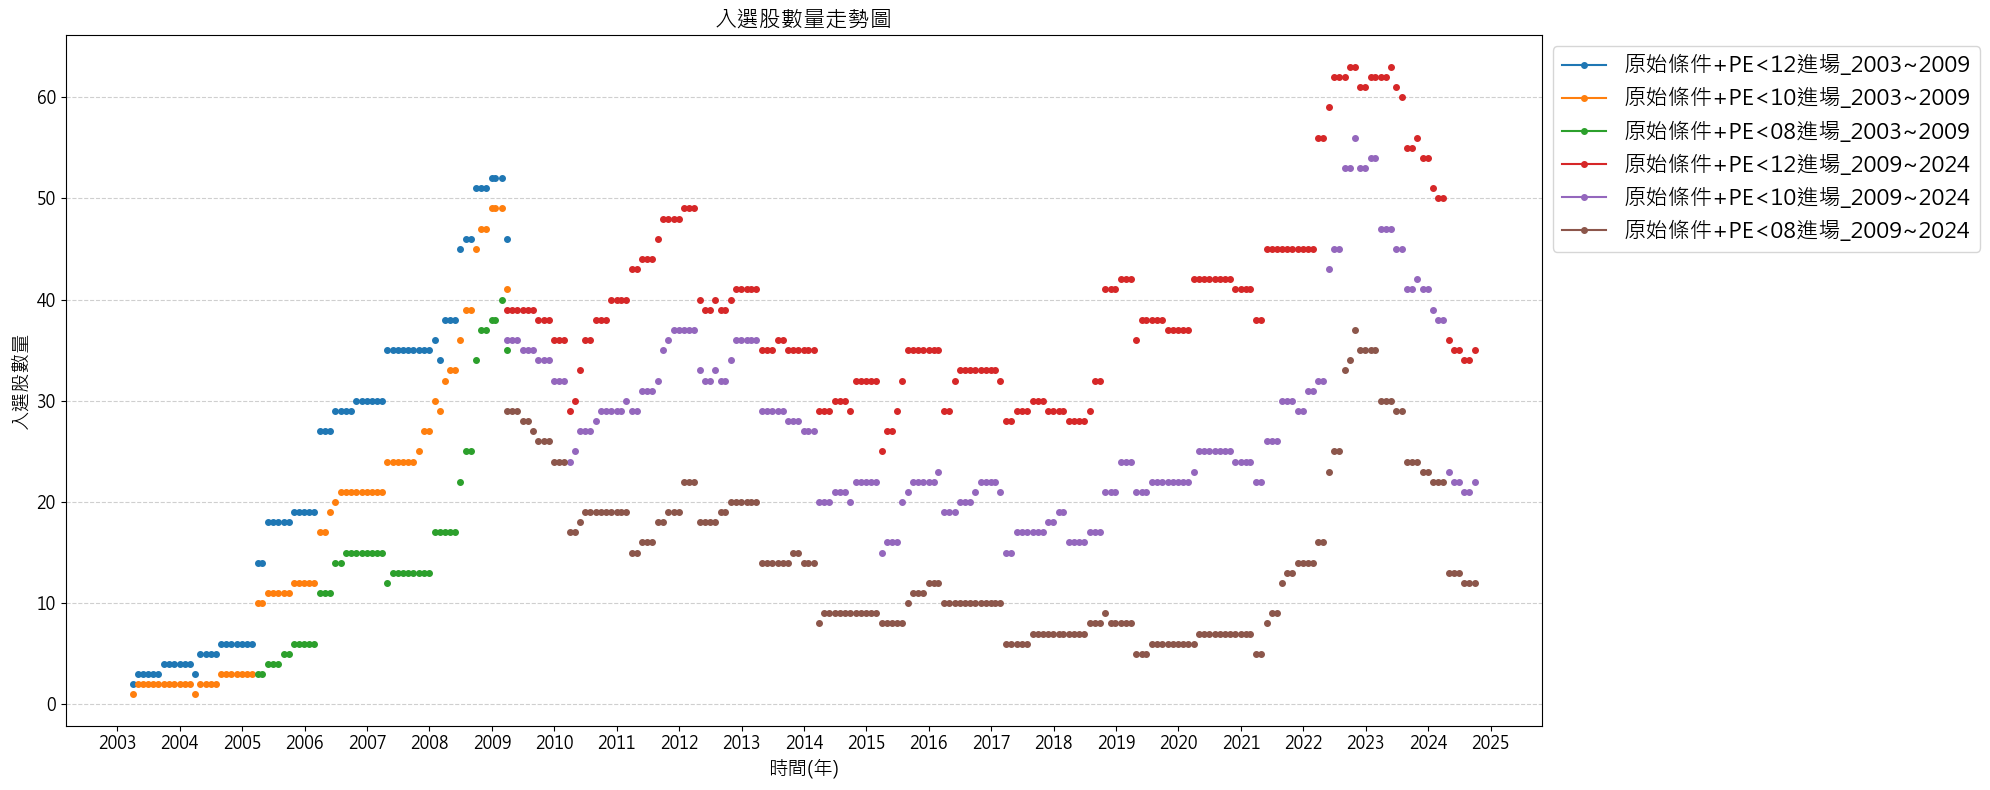

In [163]:
over_rep_collecs.plot_reps_stock_counts()

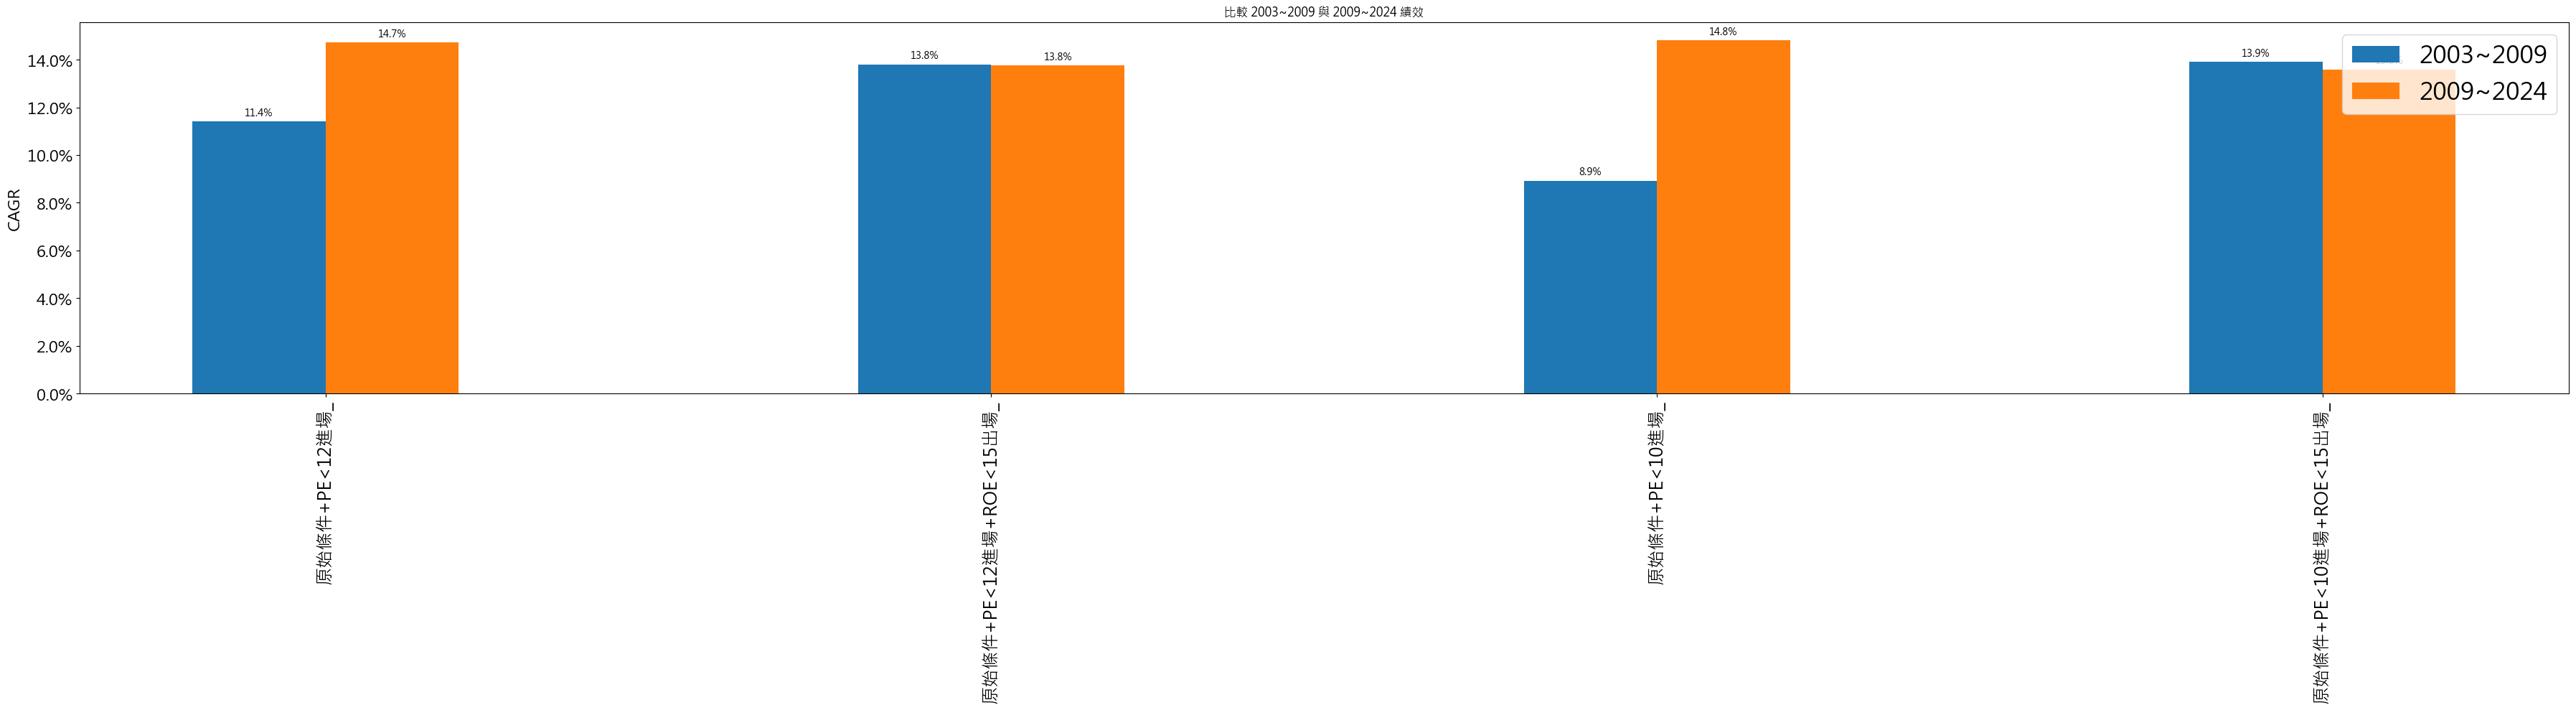

In [97]:
over_rep_collecs.compare_strat_perform('2003~2009', '2009~2024')

In [98]:
over_rep_collecs.reports['原始條件+PE<10進場_2003~2009'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     8.93%  53.45      -56.27%    43.33%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-05-02 2009-04-01     2008-04-30    2009-03-31  0.030303     228   
1473     2003-05-02 2009-04-01     2003-04-30    2009-03-31  0.500000    1469   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.100000     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.100000     991   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.041667     476   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.058824     743   
2401     2006-08-01 2009-04-01     2006-07-31    2009-03-31  0.047619     660   
2603     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.027778     186   
3014     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.020408      57   
3033     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.041667     476   
5434     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.027778     186   
6203     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.027778     186   
6206     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.025641     164   
6277     2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.033333     284   
6281     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.025641     164   
6505     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.058824     743   
9921     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.021277     100   
9925     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.022222     122   
9927     2007-12-03 2009-04-01     2007-11-30    2009-03-31  0.037037     327   
1710     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
1723     2004-05-03        NaT     2004-04-30           NaT  0.500000    5031   
2006     2008-08-01        NaT     2008-07-31           NaT  0.025641    3977   
2103     2007-05-02        NaT     2007-04-30           NaT  0.041667    4289   
2360     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
2365     2006-06-01        NaT     2006-05-30           NaT  0.052632    4516   
2374     2008-04-01        NaT     2008-03-31           NaT  0.031250    4062   
2382     2008-04-01        NaT     2008-03-31           NaT  0.031250    4062   
2395     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
2397     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
2404     2005-06-01        NaT     2005-05-31           NaT  0.090909    4763   
2439     2008-11-03        NaT     2008-10-31           NaT  0.021277    3913   
2450     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
2451     2008-02-01        NaT     2008-01-31           NaT  0.033333    4097   
2495     2007-11-01        NaT     2007-10-31           NaT  0.040000    4162   
2498     2008-11-03        NaT     2008-10-31           NaT  0.021277    3913   
2536     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
2548     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
2606     2005-04-01        NaT     2005-03-31           NaT  0.100000    4804   
2617     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
3010     2007-05-02        NaT     2007-04-30           NaT  0.041667    4289   
3015     2008-04-01        NaT     2008-03-31           NaT  0.031250    4062   
3026     2009-04-01        NaT     2009-03-31           NaT  0.024390    3813   
3034     2007-12-03        NaT     2007-11-30           NaT  0.037037    4140   
3035     2009-01-05        NaT     2008-12-31           NaT  0.020408    3870   
3293     2008-10-01        NaT     2008-09-30           NaT  0.022222    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.022222    3935   
5347     2008-04-01        NaT     2008-03-31           NaT  0.031250    4062   
5471     2008-10-01        NaT     2008-

In [99]:
over_rep_collecs.reports['原始條件+PE<10進場+ROE<15出場_2003~2009'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    13.92%  47.69      -55.16%     42.5%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-05-02 2009-04-01     2008-04-30    2009-03-31  0.035714     228   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
1710     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
2006     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
2404     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
2439     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.023256     100   
2603     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
3010     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
3014     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.022222      57   
3015     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
3035     2009-01-05 2009-04-01     2008-12-31    2009-03-31  0.022222      57   
5347     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.037037     249   
5434     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
6139     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.066667     743   
6188     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
6203     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.031250     186   
6206     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
6277     2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.035714     284   
6281     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.028571     164   
6505     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.066667     743   
9921     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.023256     100   
9925     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.024390     122   
9927     2007-12-03 2009-04-01     2007-11-30    2009-03-31  0.041667     327   
1723     2004-05-03        NaT     2004-04-30           NaT  1.000000    5031   
2103     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
2360     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2365     2006-06-01        NaT     2006-05-30           NaT  0.062500    4516   
2374     2008-04-01        NaT     2008-03-31           NaT  0.037037    4062   
2382     2008-04-01        NaT     2008-03-31           NaT  0.037037    4062   
2395     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2397     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2450     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2451     2008-02-01        NaT     2008-01-31           NaT  0.035714    4097   
2495     2007-11-01        NaT     2007-10-31           NaT  0.045455    4162   
2498     2008-11-03        NaT     2008-10-31           NaT  0.023256    3913   
2536     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
2548     2006-04-03        NaT     2006-03-31           NaT  0.066667    4556   
2606     2005-04-01        NaT     2005-03-31           NaT  0.125000    4804   
2617     2009-04-01        NaT     2009-03-31           NaT  0.033333    3813   
3034     2007-12-03        NaT     2007-11-30           NaT  0.041667    4140   
3293     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5471     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5478     2008-10-01        NaT     2008-09-30           NaT  0.024390    3935   
5508     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
5534     2009-04-01        NaT     2009-

In [100]:
# over_rep_collecs.plot_reps_stock_counts(['原始條件(PE<12進場)', '原始條件+PE<10進場', '原始條件+PE<10進場+ROE<15出場'])

---

## 限制入選股數 (老師說盡量不要用所以只保留比較MDD的程式)

### 原始條件 (盈再率<40%，本益比<12進場)，入選股數限制=5

In [101]:
# report_5 = limit5_stocks_collec.reports['原始條件限制股數(5檔)_配息率排序']
# report_10 = limit10_stocks_collec.reports['原始條件限制股數(10檔)_配息率排序']
# report_orig = rep_orig_opt_pe_daily

# # benchmark = data.get('taiex:close')['2009':]
# benchmark_drawdown = report_5.calc_dd(report_5.daily_benchmark) * 100


# tmp_1 = report_5.calc_dd(report_5.stock_data['portfolio_returns'])*100
# tmp_2 = report_10.calc_dd(report_10.stock_data['portfolio_returns'])*100
# tmp_3 = report_orig.calc_dd(report_orig.stock_data['portfolio_returns'])*100

# benchmark = benchmark_drawdown



# plt.figure(figsize=(12, 6))

# # Plot each dataset on the same graph
# # plt.plot(tmp_1.index, tmp_1.values, label='限制股數5檔 配息率排序', color='tab:blue')
# plt.plot(tmp_2.index, tmp_2.values, label='限制股數10檔 配息率排序', color='tab:orange')
# plt.plot(tmp_3.index, tmp_3.values, label='原始條件', color='tab:blue', alpha=0.7)
# # plt.plot(benchmark.index, benchmark.values, label='Benchmark', linestyle='-', color='gray', linewidth=1.5, alpha=0.6)

# plt.title('最大交易回落(MDD)')
# plt.xlabel('時間(年)')
# plt.ylabel('MDD(%)')

# plt.legend()

# plt.grid(True, alpha=0.7, linestyle='--')

# plt.show()

---

In [270]:
payout_roe_opts = {}

conds_without_roe_payout = rr_cond & profit_cond & hold_cond & listed #[START_DATE:END_DATE]

for i in range(0, 76, 5):
    # for j in range(10, 13, 2):
    for k in range(10, 26, 5):

        roe_cond_opt = (roe.rolling(5).mean() > k)

        payout_ratio_cond_opt = payout_ratio.rolling(3).min() >= i
        # per_entry_opt = (daily_pe.resample('M').last() < 12)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        
        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

        payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & pe_cond_entry_daily['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | pe_cond_exit_daily['2009-3':])

payout_roe_opts_comb = sim_conditions(payout_roe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 64/64 [03:45<00:00,  3.53s/condition]


In [209]:
# payout_roe_opts_comb.reports['配息_25%_ROE_25'].display()

In [272]:
payout_roe_opts_comb.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min    Max
Strategy                                                               
配息_70%_ROE_15     15.83   -30.14   12.76  13.0  10.0  15.0   4.0   21.0
配息_70%_ROE_10     15.24   -26.85   19.89  20.0  15.5  25.0   4.0   35.0
配息_45%_ROE_10     15.10   -29.87   59.38  54.0  46.0  71.0  29.0  100.0
配息_40%_ROE_10     15.06   -29.83   63.83  59.0  53.0  74.0  34.0  104.0
配息_45%_ROE_15     15.05   -30.55   36.67  36.0  31.0  41.0  23.0   58.0
...                 ...      ...     ...   ...   ...   ...   ...    ...
配息_50%_ROE_25      8.55   -38.04    7.17   7.0   4.0  10.0   3.0   15.0
配息_45%_ROE_25      8.19   -38.04    8.58   9.0   5.0  11.0   3.0   17.0
配息_40%_ROE_25      7.91   -38.04    9.32   9.0   5.0  12.0   3.0   21.0
配息_55%_ROE_25      7.06   -37.62    6.25   7.0   4.0   8.0   1.0   13.0
配息_75%_ROE_25      2.71   -31.93    1.16   1.0   0.0   2.0   0.0    4.0

[64 rows x 8 columns]

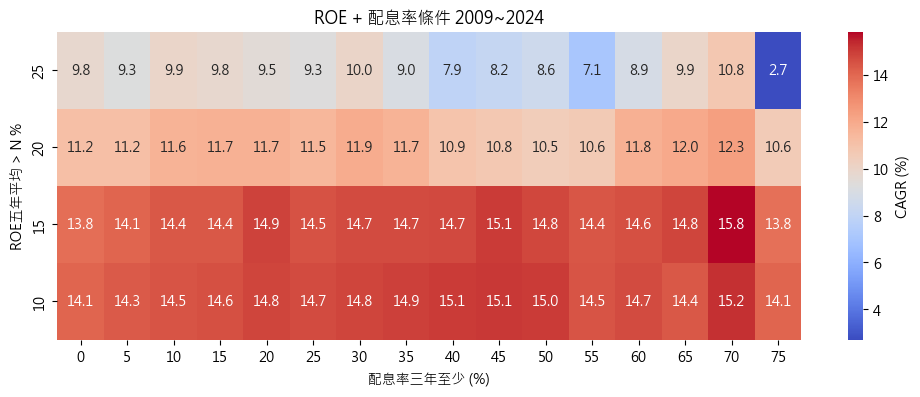

In [273]:
df = payout_roe_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Plotting the heatmap with reversed Y-axis, in coolwarm color scheme, and custom labels
plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("ROE五年平均 > N %")
plt.title("ROE + 配息率條件 2009~2024")
plt.show()

In [223]:
payout_roe_opts_comb.reports['配息_25%_ROE_25'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    18.65%  51.15      -60.36%     55.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.111111     991   
3010     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
6188     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.047619     476   
6206     2008-08-01 2009-04-01     2008-07-31    2009-03-31  0.045455     164   
6277     2005-12-01 2009-04-01     2005-11-30    2009-03-31  0.083333     823   
6505     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.047619     186   
1565     2009-04-01        NaT     2009-03-31           NaT  0.041667    3813   
1723     2005-04-01        NaT     2005-03-31           NaT  0.111111    4804   
2451     2006-04-03        NaT     2006-03-31           NaT  0.076923    4556   
2495     2005-04-01        NaT     2005-03-31           NaT  0.111111    4804   
2498     2007-02-01        NaT     2007-01-31           NaT  0.062500    4344   
2548     2008-05-02        NaT     2008-04-30           NaT  0.050000    4041   
2606     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
3008     2007-09-03        NaT     2007-08-31           NaT  0.045455    4202   
3034     2004-10-01        NaT     2004-09-30           NaT  1.000000    4926   
3035     2009-01-05        NaT     2008-12-31           NaT  0.037037    3870   
3059     2007-05-02        NaT     2007-04-30           NaT  0.047619    4289   
3227     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
3293     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
3504     2009-04-01        NaT     2009-03-31           NaT  0.041667    3813   
5471     2006-04-03        NaT     2006-03-31           NaT  0.076923    4556   
5508     2008-04-01        NaT     2008-03-31           NaT  0.052632    4062   
5534     2008-04-01        NaT     2008-03-31           NaT  0.052632    4062   
6121     2008-10-01        NaT     2008-09-30           NaT  0.038462    3935   
6202     2008-01-02        NaT     2007-12-31           NaT  0.043478    4119   
8072     2008-02-01        NaT     2008-01-31           NaT  0.040000    4097   
8299     2008-03-03        NaT     2008-02-29           NaT  0.038462    4083   
8924     2005-04-01        NaT     2005-03-31           NaT  0.111111    4804   
9940     2009-04-01        NaT     2009-03-31           NaT  0.041667    3813   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
1477             1319        2310   0.145771 -0.260041   2.106229  2.106229   
3010             1834        2310  -0.522598 -0.631761   0.276960  0.276960   
6188             1834        2310  -0.206259 -0.441378   0.473064  0.473064   
6206             2146        2310  -0.201893 -0.446088   0.142638  0.142638   
6277             1487        2310  -0.158814 -0.253708   1.958046  1.958046   
6505             2124        2310  -0.192663 -0.319902   0.000000  0.000000   
1565             2310          -1   2.196460 -0.086614  10.296204  0.015748   
1723             1319          -1   5.496392 -0.114369   7.093658  0.049635   
2451             1567          -1   5.932373 -0.100692   7.584198  2.553764   
2495             1319          -1   1.060278 -0.481990   1.256477  0.977414   
2498             1779          -1  -0.724873 -0.840077   5.147259  5.147259   
2548             2082          -1   4.399511 -0.737247   5.909109  0.076923   
2606             1834          -1   1.603260 -0.377839   2.432490  1.044065   
3008             1921          -1  13.230781 -0.359189  26.481069  0.680578   
3034             1197          -1  29.396601 -0.496458  34.572804  2.352985   
3035             2253          -1  11.637156 -0.045743  20.186114  1.6304

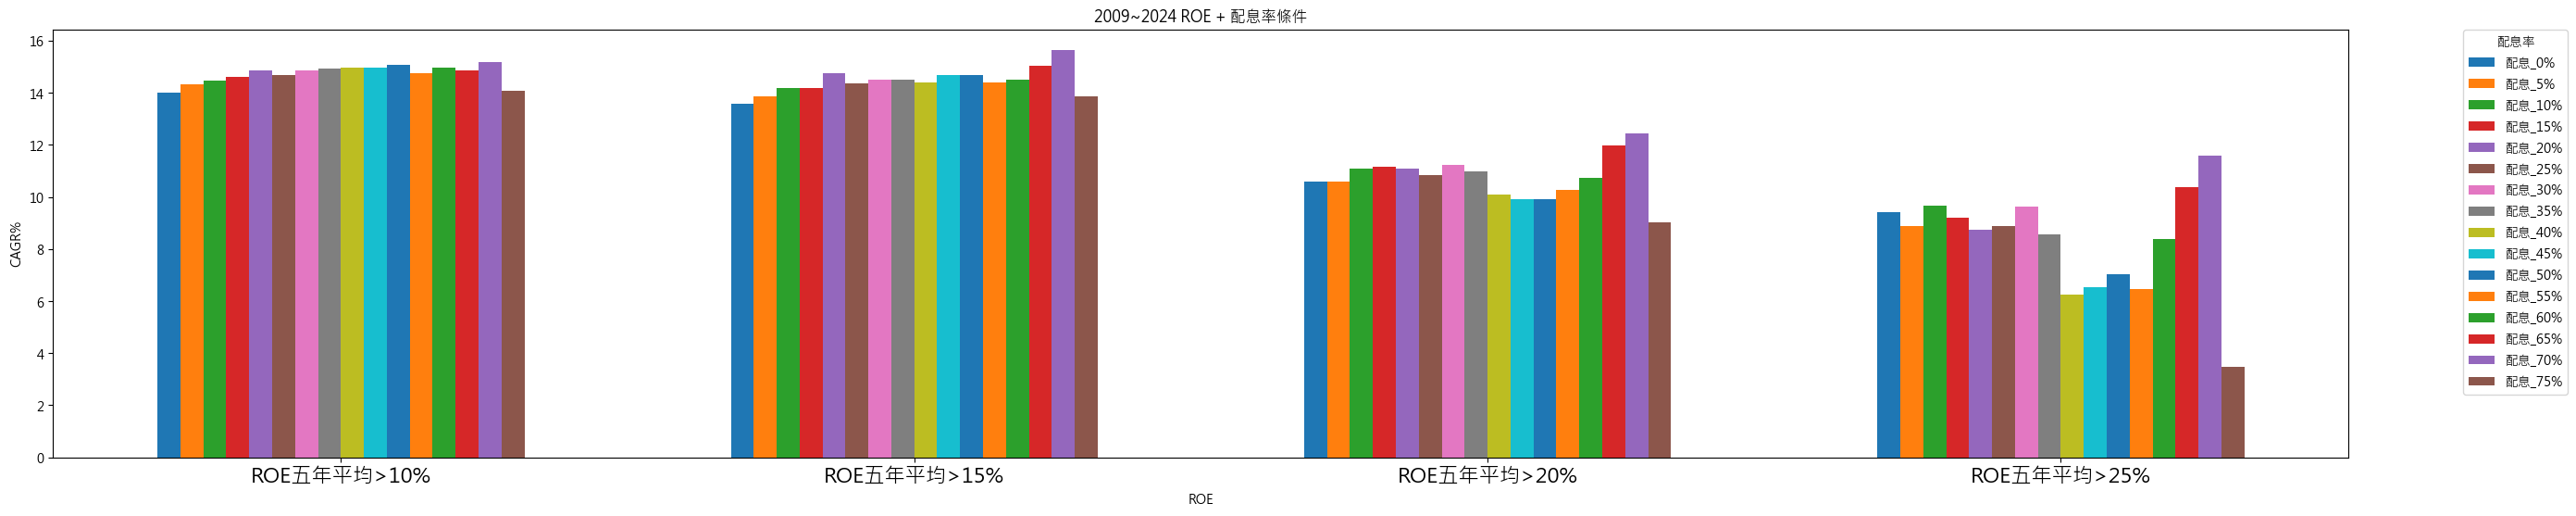

In [220]:
df = payout_roe_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on new format
# '配息_{N}%' for 配息率 and 'ROE_{X}' for ROE
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 N
df['X'] = df.index.map(lambda x: x.split('_')[-1])                 # Extracting ROE X

# Converting to numeric types for proper sorting
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Sorting values by 'X' (ROE) and 'N' (配息率) for correct order in the plot
df.sort_values(by=['X', 'N'], inplace=True)

# Unique values for 配息率 (N) and ROE (X) for grouping and bar placement
unique_n_values = sorted(df['N'].unique())
unique_x_values = sorted(df['X'].unique())

# Plotting
fig, ax = plt.subplots(figsize=(32, 6))
bar_width = 0.04  # Width for each bar within a group

# Plot each 配息率 (N) as a separate set of bars within each ROE (X) group
for i, n_value in enumerate(unique_n_values):
    # Selecting data for the specific 配息率 (N) within each ROE (X) group
    bar_positions = [pos + i * bar_width for pos in range(len(unique_x_values))]
    cagr_values = [df[(df['X'] == x_value) & (df['N'] == n_value)]['CAGR (%)'].values[0]
                   if ((df['X'] == x_value) & (df['N'] == n_value)).any() else 0
                   for x_value in unique_x_values]
    
    # Plot bars
    ax.bar(bar_positions, cagr_values, width=bar_width, label=f'配息_{n_value}%')

# Customizing x-axis with sorted 'ROE' values as labels
ax.set_xticks([pos + (bar_width * (len(unique_n_values) - 1) / 2) for pos in range(len(unique_x_values))])
ax.set_xticklabels([f'ROE五年平均>{x}%' for x in unique_x_values], fontsize=16)

# Adding labels, title, and moving legend outside the plot area
plt.xlabel("ROE")
plt.ylabel("CAGR%")
plt.title("2009~2024 ROE + 配息率條件")
plt.legend(title="配息率", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Display plot
plt.show()